In [1]:
!pip install torchsummary

In [2]:
import torch
import torchvision

In [3]:
import os
import time
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

### Скачиваем датасет

In [4]:
# !wget https://figshare.com/ndownloader/files/34792480 -O Confirmed_fronts.zip

In [5]:
# !unzip -q Confirmed_fronts.zip

### Парсим каталог с изображениями

In [6]:
!if [ -d dataset/ ]; then rm -r dataset/; fi

In [7]:
import glob
import re

map = {}
# max_len = 6095
for filename in glob.iglob('./confirmed_fronts/*/*/*[jpg]', recursive=True):
    x = re.search("([^$]+)\\$\\$([^$]+)\\$\\$([^$]+)\\$\\$([^$]+)\\$\\$([^$]+)\\$\\$([^$]+)\\$\\$i([^$]+)", filename)
    if x:
        color = x.group(4).lower()
        if color not in map:
            map[color] = []

        # if len(map[color]) < max_len:
        map[color].append(filename)

print(map.keys())

dict_keys(['black', 'beige', 'red', 'blue', 'silver', 'grey', 'white', 'multicolour', 'purple', 'brown', 'green', 'unlisted', 'gold', 'yellow', 'bronze', 'orange', 'maroon', 'burgundy', 'pink', 'turquoise', 'navy', 'magenta', 'indigo'])


### Удаляем категории в которых мало изображений

In [8]:
min_len = 500

for cls in list(map.keys()):
    cls_len = len(map[cls])
    if cls_len < min_len:
        del map[cls]
        continue

# Удалил silver и grey так как они трудно-отличимы друг от друга и от black
del map['beige']
del map['silver']
del map['grey']
del map['unlisted']
print(map.keys())

dict_keys(['black', 'red', 'blue', 'white', 'brown', 'green', 'yellow', 'orange'])


### Выравниваем классы по количеству изображений

In [9]:
min_cls_len = 10e10
for cls in list(map.keys()):
    if len(map[cls]) < min_cls_len:
        min_cls_len = len(map[cls])

print(f"min_cls_len: {min_cls_len}")

for cls in list(map.keys()):
    map[cls] = map[cls][0:min_cls_len]

min_cls_len: 559


### Делим датасет на test и train и составляем список классов в labels.csv

In [10]:
import os
import shutil
import random
import numpy as np

classes = list(map.keys())
counter = 0
test_ratio = 0.05
labels = [('id', 'cls')]
test_images = []
train_images = []

for cls in classes:
    filenames = map[cls]
    num = len(filenames)
    test_size = int(num * test_ratio)
    test_files = random.sample(filenames, test_size)

    for fn in filenames:
        counter += 1
        id = f"{cls}_{counter}"
        new_fn = f"{id}.jpg"
        labels.append((id, cls))
        if fn in test_files:
            dest_path = f"./dataset/test/{new_fn}"
            test_images.append(dest_path)
        else:
            dest_path = f"./dataset/train/{new_fn}"
            train_images.append(dest_path)
        os.makedirs(os.path.dirname(dest_path), exist_ok=True)
        shutil.copy(fn, dest_path)

np.savetxt('./dataset/labels.csv', labels, delimiter=',', fmt='%s')

In [11]:
import pandas as pd

dataset_root = './dataset'

labels = pd.read_csv(f'{dataset_root}/labels.csv')
labels.head()

id    cls
0  black_1  black
1  black_2  black
2  black_3  black
3  black_4  black
4  black_5  black

In [12]:
img_name_to_label = labels.set_index('id')['cls'].to_dict()
list(img_name_to_label.items())[:10]

[('black_1', 'black'),
 ('black_2', 'black'),
 ('black_3', 'black'),
 ('black_4', 'black'),
 ('black_5', 'black'),
 ('black_6', 'black'),
 ('black_7', 'black'),
 ('black_8', 'black'),
 ('black_9', 'black'),
 ('black_10', 'black')]

In [13]:
classes = sorted(labels['cls'].unique())
classes

['black', 'blue', 'brown', 'green', 'orange', 'red', 'white', 'yellow']

./dataset/train/black_1.jpg


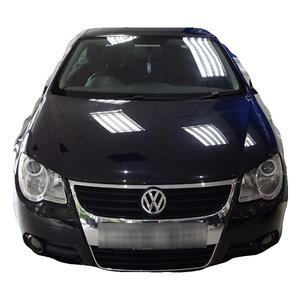

In [14]:
import cv2
from PIL import Image

print(train_images[0])
Image.open(train_images[0])

In [15]:
from sklearn.model_selection import train_test_split
import numpy as np

img_names = sorted(os.listdir(f'{dataset_root}/train'))
total_imgs = len(img_names)
targets = [img_name_to_label[img_name.replace('.jpg', '')] for img_name in img_names]
train_set_inds, test_set_inds = train_test_split(np.arange(total_imgs), test_size=0.1, random_state=42,
                                                 stratify=targets)

In [16]:
train_img_names = [img_names[ind] for ind in train_set_inds]
test_img_names = [img_names[ind] for ind in test_set_inds]

In [17]:
from torchvision import transforms as T

# ресайзим изображения до 224 (размер нашего входа)
img_sz = 224

# преобразуем в тензор и нормализуем
# стандартные значения нормализации вычисленные математически
normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_data_transforms = T.Compose([
    T.Resize((img_sz, img_sz)),
    T.ToTensor(),
    normalize
])
test_data_transforms = T.Compose([
    T.Resize((img_sz, img_sz)),
    T.ToTensor(),
    normalize
])

### Инициализируем ImageDataset'ы для доступа к данным

In [18]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd


class ImageDataset(Dataset):
    def __init__(self, dataset_root, classes, img_name_to_label,
                 img_names, transform):
        self.dataset_root = dataset_root
        self.img_names = img_names
        self.img_name_to_label = img_name_to_label
        self.label_to_idx = {val: idx for idx, val in enumerate(classes)}
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, index):
        img_name = self.img_names[index]
        img_path = f'{self.dataset_root}/{img_name}'
        label = self.img_name_to_label[img_name.replace('.jpg', '')]
        image = Image.open(img_path).convert('RGB')

        image_tensor = self.transform(image)
        image.close()
        return image_tensor, self.label_to_idx[label]

In [19]:
image_datasets = dict()
image_datasets['train'] = ImageDataset(dataset_root=f"{dataset_root}/train",
                                       classes=classes,
                                       img_name_to_label=img_name_to_label,
                                       img_names=train_img_names,
                                       transform=train_data_transforms)

image_datasets['test'] = ImageDataset(dataset_root=f"{dataset_root}/train",
                                      classes=classes,
                                      img_name_to_label=img_name_to_label,
                                      img_names=test_img_names,
                                      transform=test_data_transforms)

## Инициализируем DataLoader'ы

In [20]:
from torch.utils.data import DataLoader

batch_size = 256
num_workers = 16

dataloaders = dict()
dataloaders['train'] = DataLoader(image_datasets['train'],
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=num_workers,
                                  pin_memory=True,
                                  drop_last=True)
dataloaders['test'] = DataLoader(image_datasets['test'],
                                 batch_size=batch_size,
                                 shuffle=False,
                                 num_workers=num_workers,
                                 pin_memory=True)

### Для обучения будем использовать 3 предобученные модели:
  - ResNet50
  - AlexNet
  - VGG19

(выбор пал на них, т.к. их мне лучше всего удалось дообучить)

### ResNet50

In [21]:
from torchvision import models
from torch import nn
import torch


def get_resnet(num_classes):
    net_features = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    # net_features = models.resnet101(weights=models.ResNet101_Weights.DEFAULT)

    net_features.requires_grad_(False)
    net_features.fc = nn.Sequential(
        nn.Linear(2048, 1024),
        nn.Dropout(0.1),
        nn.ReLU(),
        nn.Linear(1024, 256),
        nn.Dropout(0.1),
        nn.ReLU(),
        nn.Linear(256, num_classes)
    )
    return net_features

### AlexNet

In [22]:
from torchvision import models
from torch import nn
import torch


def get_alexnet(num_classes):
    net_features = models.alexnet(weights=models.AlexNet_Weights.DEFAULT)
    net_features.requires_grad_(False)

    dropout = 0.5

    net_features.classifier = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(p=dropout),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, num_classes),
    )
    return net_features

### VGG

In [23]:
from torchvision import models
from torch import nn
import torch


def get_vgg(num_classes):
    net_features = models.vgg19(weights=models.VGG19_Weights.DEFAULT)
    net_features.requires_grad_(False)

    dropout = 0.5
    net_features.classifier = nn.Sequential(
        nn.Linear(512 * 7 * 7, 4096),
        nn.ReLU(True),
        nn.Dropout(p=dropout),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(p=dropout),
        nn.Linear(4096, num_classes),
    )

    return net_features

### Инициализируем модели

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net_models = {}
net_models['resnet'] = get_resnet(num_classes=len(classes)).to(device)
net_models['alexnet'] = get_alexnet(num_classes=len(classes)).to(device)
net_models['vgg'] = get_vgg(num_classes=len(classes)).to(device)

### Выводим полученные архитектуры нейронных сетей

In [25]:
from torchsummary import summary

for name in list(net_models.keys()):
    print(name)
    summary(net_models[name], input_size=(3, 224, 224))

resnet
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-

### Обучение

In [26]:
from sklearn import metrics


def run_epoch(phase, dataloader):
    if phase == 'train':
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    running_corrects = 0
    y_test = []
    y_pred = []
    all_elems_count = 0
    cur_tqdm = tqdm(dataloader)
    for inputs, labels in cur_tqdm:
        bz = inputs.shape[0]
        all_elems_count += bz

        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        if phase == 'train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        _, preds = torch.max(outputs, 1)
        y_test.extend(labels.detach().cpu().numpy())
        y_pred.extend(preds.detach().cpu().numpy())
        running_loss += loss.item() * bz
        corrects_cnt = torch.sum(preds == labels.detach())
        running_corrects += corrects_cnt
        show_dict = {'Loss': f'{loss.item():.6f}',
                     'Corrects': f'{corrects_cnt.item()}/{bz}',
                     'Accuracy': f'{(corrects_cnt * 100 / bz).item():.3f}%'}
        cur_tqdm.set_postfix(show_dict)

    conf_matrix = metrics.confusion_matrix(y_test, y_pred)

    print("Calculating metrics...")
    f05_macro = metrics.fbeta_score(y_test, y_pred, average="macro", beta=0.5)
    f1_macro = metrics.f1_score(y_test, y_pred, average="macro")
    epoch_loss = running_loss / all_elems_count
    epoch_acc = running_corrects.float().item() / all_elems_count
    return epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix


def test_epoch(dataloader):
    with torch.inference_mode():
        return run_epoch('test', dataloader)


def train_epoch(dataloader):
    return run_epoch('train', dataloader)

In [27]:
import time
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

log_folder = 'logs'
os.makedirs(log_folder, exist_ok=True)

results = {}


def train_model(name, dataloaders, num_epochs=5):
    print(f"Training model with params:")
    print(f"Optim: {optimizer}")
    print(f"Criterion: {criterion}")

    phases = ['train', 'test']
    for phase in dataloaders:
        if phase not in phases:
            phases.append(phase)

    results[name] = {'train': (), 'test': ()}

    saved_epoch_losses = {phase: [] for phase in phases}
    saved_epoch_accuracies = {phase: [] for phase in phases}
    saved_epoch_f1_macros = {phase: [] for phase in phases}

    for epoch in range(1, num_epochs + 1):
        start_time = time.time()

        print("=" * 100)
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            print("--- Cur phase:", phase)
            epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix = \
                train_epoch(dataloaders[phase]) if phase == 'train' \
                    else test_epoch(dataloaders[phase])
            saved_epoch_losses[phase].append(epoch_loss)
            saved_epoch_accuracies[phase].append(epoch_acc)
            saved_epoch_f1_macros[phase].append(f1_macro)
            print(f'{phase} loss: {epoch_loss:.6f}, '
                  f'acc: {epoch_acc:.6f}, '
                  f'f05_macro: {f05_macro:.6f}, '
                  f'f1_macro: {f1_macro:.6f}')
            print("Confusion matrix:")
            print(conf_matrix)

            results[name][phase] = epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix

        model.eval()
        if epoch > 1:
            plt.title(f'Losses during training. Epoch {epoch}/{num_epochs}.')
            plt.plot(range(1, epoch + 1), saved_epoch_losses['train'], label='Train Loss')
            plt.plot(range(1, epoch + 1), saved_epoch_losses['test'], label='Test Loss')
            plt.xlabel('Epochs')
            plt.ylabel(criterion.__class__.__name__)
            plt.legend(loc="upper left")
            plt.savefig(f'{log_folder}/loss_graph_{name}_epoch{epoch + 1}.png')
            plt.show()
            plt.close('all')

            plt.title(f'Accuracies during training. Epoch {epoch}/{num_epochs}.')
            plt.plot(range(1, epoch + 1), saved_epoch_accuracies['train'], label='Train Acc')
            plt.plot(range(1, epoch + 1), saved_epoch_accuracies['test'], label='Test Acc')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend(loc="upper left")
            plt.savefig(f'{log_folder}/acc_graph_{name}_epoch{epoch + 1}.png')
            plt.show()
            plt.close('all')

            plt.title(f'F1-macros during training. Epoch {epoch}/{num_epochs}.')
            plt.plot(range(1, epoch + 1), saved_epoch_f1_macros['train'], label='Train F1')
            plt.plot(range(1, epoch + 1), saved_epoch_f1_macros['test'], label='Test F1')
            plt.xlabel('Epochs')
            plt.ylabel('F1')
            plt.legend(loc="upper left")
            plt.savefig(f'{log_folder}/f1_graph_{name}_epoch{epoch + 1}.png')
            plt.show()
            plt.close('all')

        end_time = time.time()
        epoch_time = end_time - start_time
        print("-" * 10)
        print(f"Epoch Time: {math.floor(epoch_time // 60)}:{math.floor(epoch_time % 60):02d}")

    print("*** Training Completed ***")

    return saved_epoch_losses, saved_epoch_accuracies, saved_epoch_f1_macros

### Инициализируем гиперпараметры и запускаем обучение

Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Criterion: CrossEntropyLoss()
Epoch 1/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  2.82it/s, Loss=0.780540, Corrects=182/256, Accuracy=71.094%]


Calculating metrics...
train loss: 1.398206, acc: 0.553013, f05_macro: 0.537643, f1_macro: 0.536208
Confusion matrix:
[[191  89  61  10  26  12  38  24]
 [ 76 188  36  15  16  14  72  29]
 [ 76  18 142  72  18  23  69  30]
 [ 59  19  72 144  23  27  39  66]
 [  3   0  15   6 232 102   2  88]
 [  4   0  10   1  58 330   4  37]
 [ 10   6  12   7  19   9 371  16]
 [  2   4   5   2  39   9   3 384]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.29it/s, Loss=0.951652, Corrects=111/170, Accuracy=65.294%]


Calculating metrics...
test loss: 0.983396, acc: 0.647887, f05_macro: 0.646783, f1_macro: 0.615462
Confusion matrix:
[[ 7 41  0  1  0  1  2  1]
 [ 0 53  0  0  0  0  0  0]
 [ 4 20 13  8  1  0  4  3]
 [ 4 15  1 19  0  0  3 12]
 [ 1  1  0  0 37  2  0 12]
 [ 0  1  0  0  5 44  0  3]
 [ 1  2  0  0  0  0 51  0]
 [ 0  0  0  0  1  0  0 52]]
----------
Epoch Time: 0:05
Epoch 2/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.10it/s, Loss=0.544970, Corrects=211/256, Accuracy=82.422%]


Calculating metrics...
train loss: 0.615203, acc: 0.789062, f05_macro: 0.789332, f1_macro: 0.789087
Confusion matrix:
[[312  84  24  18   2   1   5   0]
 [ 79 324   6  22   1   0  14   0]
 [ 37  26 294  64   8   4  22   1]
 [ 31  22  64 306   3   3   7  14]
 [  1   0   8   9 366  45   0  18]
 [  5   0   3   4  31 396   1   0]
 [  8  14   7  14   0   0 405   0]
 [  0   2   1   9  14   0   0 425]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.28it/s, Loss=0.576934, Corrects=127/170, Accuracy=74.706%]


Calculating metrics...
test loss: 0.629441, acc: 0.758216, f05_macro: 0.759273, f1_macro: 0.754142
Confusion matrix:
[[24 23  3  0  0  1  2  0]
 [10 42  0  0  0  0  1  0]
 [ 7  2 34  4  2  0  4  0]
 [ 4  9  9 28  1  0  1  2]
 [ 0  0  2  1 44  4  0  2]
 [ 0  0  0  0  4 49  0  0]
 [ 0  2  0  1  0  1 50  0]
 [ 0  0  0  0  1  0  0 52]]


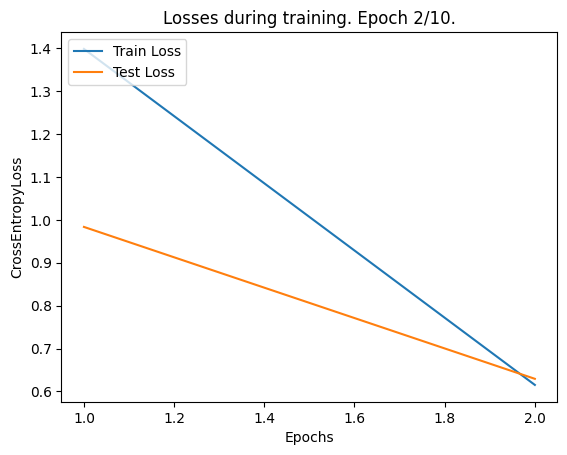

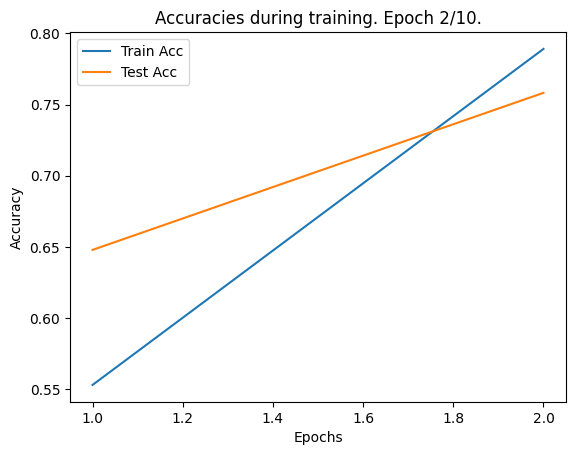

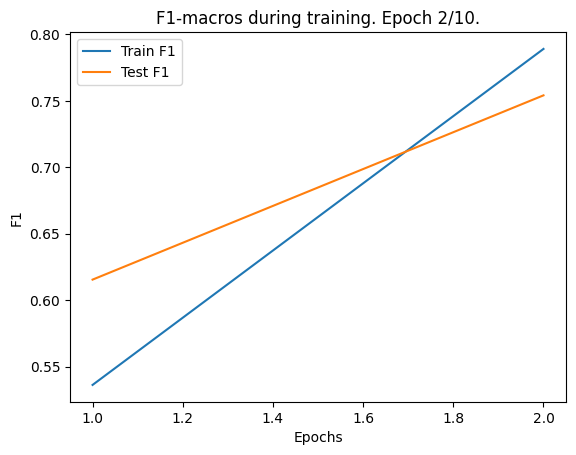

----------
Epoch Time: 0:05
Epoch 3/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.16it/s, Loss=0.380750, Corrects=219/256, Accuracy=85.547%]


Calculating metrics...
train loss: 0.426358, acc: 0.854911, f05_macro: 0.854841, f1_macro: 0.854737
Confusion matrix:
[[351  55  19  13   0   1   5   0]
 [ 64 355   7  14   0   0   9   0]
 [ 27  21 353  31   5   2  14   0]
 [ 14  16  56 341   0   0   5   9]
 [  0   0   7   6 397  29   0  15]
 [  4   2   3   1  26 415   1   0]
 [  2   3   3   3   0   0 425   0]
 [  1   2   4   7  14   0   0 427]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.26it/s, Loss=0.561788, Corrects=132/170, Accuracy=77.647%]


Calculating metrics...
test loss: 0.553422, acc: 0.786385, f05_macro: 0.789049, f1_macro: 0.785573
Confusion matrix:
[[40  7  1  3  0  1  1  0]
 [19 32  0  1  0  0  1  0]
 [ 8  0 30 11  3  0  1  0]
 [ 4  3  6 37  2  0  0  2]
 [ 0  0  3  1 45  2  0  2]
 [ 0  0  0  0  4 49  0  0]
 [ 0  1  1  1  0  0 51  0]
 [ 0  0  0  1  1  0  0 51]]


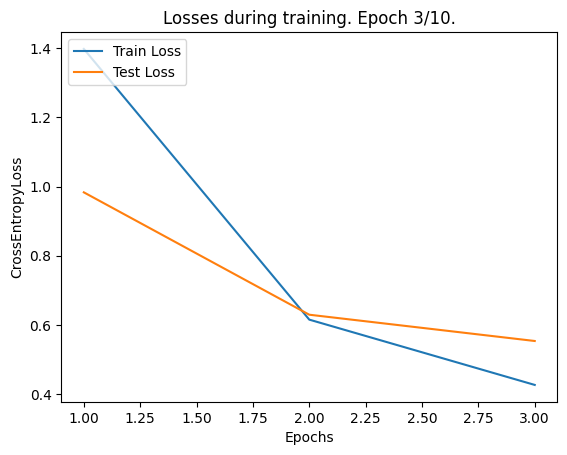

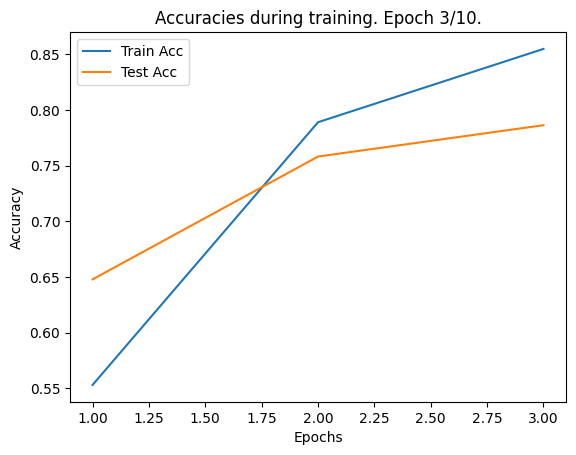

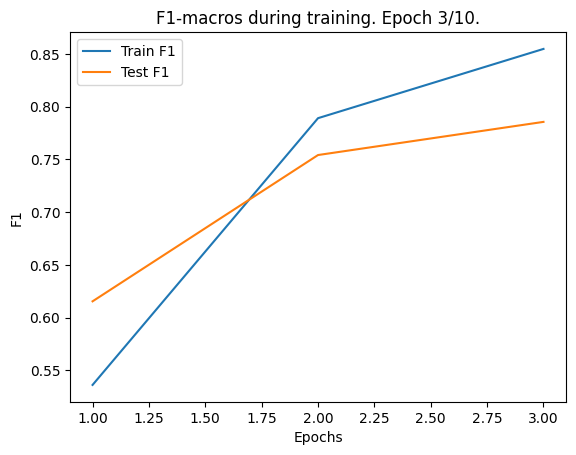

----------
Epoch Time: 0:05
Epoch 4/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.02it/s, Loss=0.339661, Corrects=225/256, Accuracy=87.891%]


Calculating metrics...
train loss: 0.312668, acc: 0.897321, f05_macro: 0.897802, f1_macro: 0.897555
Confusion matrix:
[[375  41  12   8   0   0   3   0]
 [ 43 393   6  11   0   0   2   0]
 [ 25  12 373  29   3   2   7   1]
 [ 13  10  36 384   0   0   1   5]
 [  1   0   3   5 404  23   0   8]
 [  2   2   1   0  13 423   1   0]
 [  2   6   3   3   0   0 434   0]
 [  1   2   4   6  12   0   0 430]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.25it/s, Loss=0.556005, Corrects=134/170, Accuracy=78.824%]


Calculating metrics...
test loss: 0.535699, acc: 0.805164, f05_macro: 0.804771, f1_macro: 0.803042
Confusion matrix:
[[27 14  7  3  0  1  1  0]
 [10 42  0  0  0  0  1  0]
 [ 2  0 43  6  1  0  1  0]
 [ 2  4  9 36  1  0  0  2]
 [ 0  0  3  1 47  0  0  2]
 [ 0  0  0  0  6 47  0  0]
 [ 0  1  2  1  0  0 50  0]
 [ 0  0  0  1  1  0  0 51]]


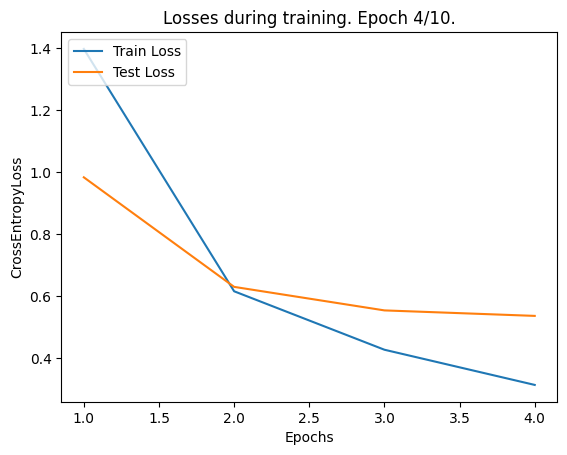

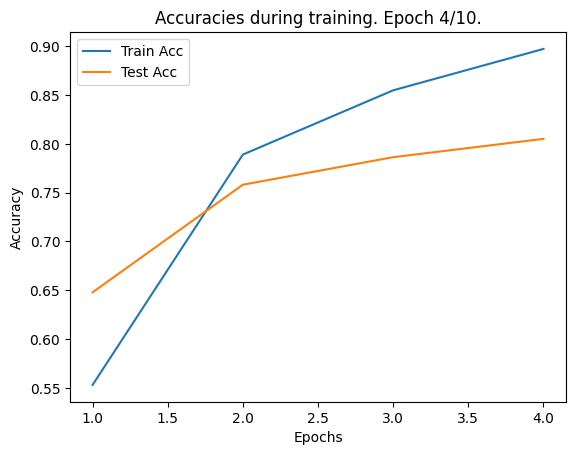

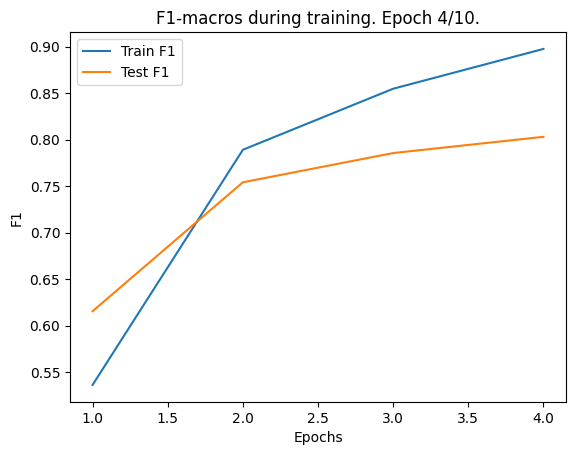

----------
Epoch Time: 0:05
Epoch 5/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.09it/s, Loss=0.232505, Corrects=237/256, Accuracy=92.578%]


Calculating metrics...
train loss: 0.233408, acc: 0.924107, f05_macro: 0.924425, f1_macro: 0.924260
Confusion matrix:
[[384  28  24   3   0   1   0   0]
 [ 28 400   7  11   0   1   4   0]
 [ 21   6 397  24   0   3   5   0]
 [  9   5  24 406   1   0   1   1]
 [  2   0   5   1 411  14   0   7]
 [  0   2   2   0   8 443   0   0]
 [  3   3   2   0   0   0 438   0]
 [  1   2   1   5   7   0   0 433]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.31it/s, Loss=0.543123, Corrects=139/170, Accuracy=81.765%]


Calculating metrics...
test loss: 0.518387, acc: 0.809859, f05_macro: 0.809911, f1_macro: 0.809314
Confusion matrix:
[[32 12  4  3  0  1  1  0]
 [12 41  0  0  0  0  0  0]
 [ 4  0 35 12  1  0  1  0]
 [ 2  4  5 40  1  0  0  2]
 [ 0  0  2  1 47  1  0  2]
 [ 0  0  0  0  5 48  0  0]
 [ 0  1  1  1  0  0 51  0]
 [ 0  0  0  1  1  0  0 51]]


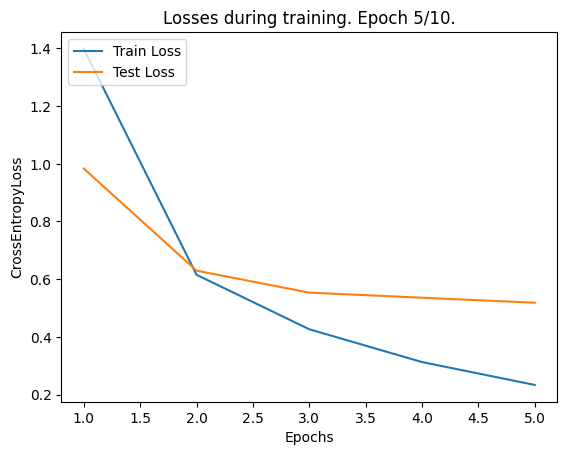

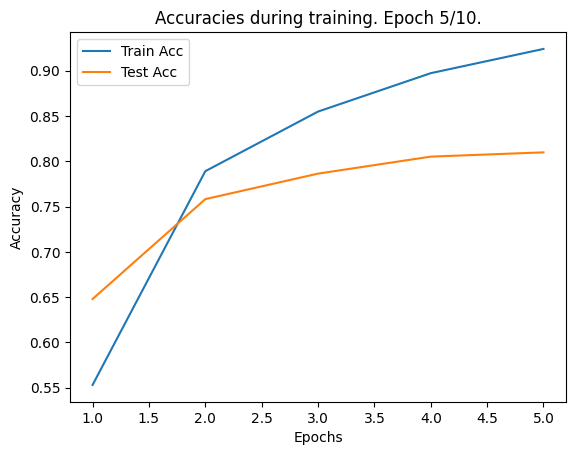

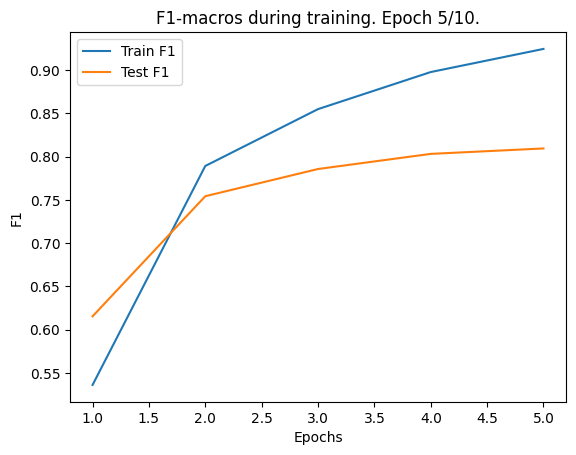

----------
Epoch Time: 0:05
Epoch 6/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.19it/s, Loss=0.168857, Corrects=242/256, Accuracy=94.531%]


Calculating metrics...
train loss: 0.177521, acc: 0.943359, f05_macro: 0.943665, f1_macro: 0.943633
Confusion matrix:
[[409  26  10   3   0   0   2   0]
 [ 31 405   6   7   0   0   0   0]
 [  7   7 417  16   2   1   2   0]
 [  9   2  20 417   1   0   1   5]
 [  1   0   4   0 424  10   0   7]
 [  0   0   3   0   8 437   1   0]
 [  0   0   0   1   0   0 435   0]
 [  0   2   1   3   4   0   0 437]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.28it/s, Loss=0.595809, Corrects=134/170, Accuracy=78.824%]


Calculating metrics...
test loss: 0.609677, acc: 0.798122, f05_macro: 0.801219, f1_macro: 0.793550
Confusion matrix:
[[32 16  0  3  0  1  1  0]
 [ 5 48  0  0  0  0  0  0]
 [ 8  4 24 13  3  0  1  0]
 [ 1  8  3 39  1  0  0  2]
 [ 0  1  2  0 46  2  0  2]
 [ 0  0  0  0  2 51  0  0]
 [ 0  4  0  0  0  0 50  0]
 [ 0  0  0  1  2  0  0 50]]


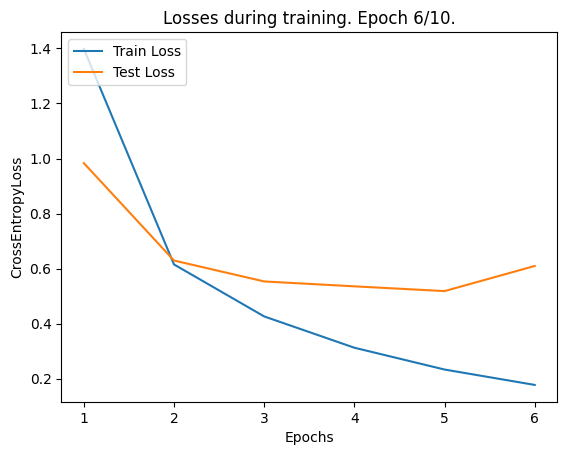

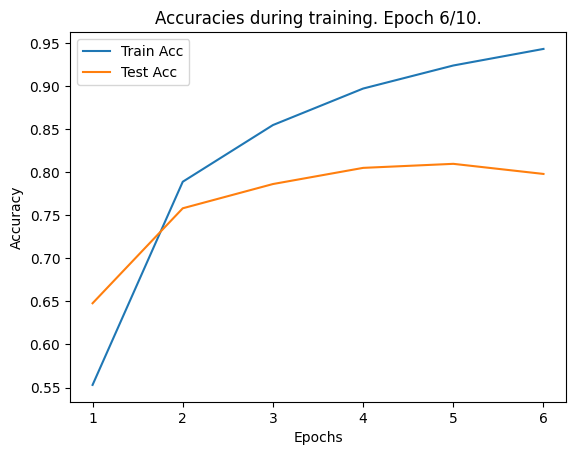

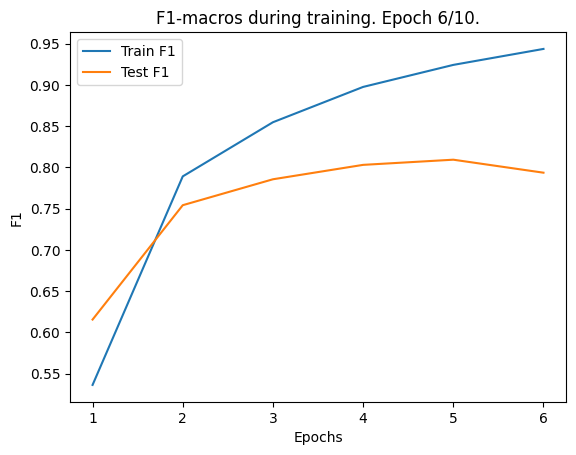

----------
Epoch Time: 0:05
Epoch 7/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.13it/s, Loss=0.159543, Corrects=244/256, Accuracy=95.312%]


Calculating metrics...
train loss: 0.155192, acc: 0.949219, f05_macro: 0.949651, f1_macro: 0.949507
Confusion matrix:
[[406  24   9   3   0   0   0   0]
 [ 22 423   6   3   0   0   1   0]
 [ 16  10 406  16   2   1   1   1]
 [  9   4  17 420   0   0   0   1]
 [  1   0   2   0 438   5   0   5]
 [  1   1   3   0   5 427   0   0]
 [  1   3   1   0   0   0 438   0]
 [  2   0   1   2   3   0   0 444]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.25it/s, Loss=0.615680, Corrects=134/170, Accuracy=78.824%]


Calculating metrics...
test loss: 0.579326, acc: 0.791080, f05_macro: 0.789026, f1_macro: 0.783714
Confusion matrix:
[[21 11  8  8  1  3  1  0]
 [ 5 41  2  3  0  0  2  0]
 [ 1  0 33 14  3  1  1  0]
 [ 0  2  3 47  2  0  0  0]
 [ 0  0  2  1 46  2  0  2]
 [ 0  0  0  0  2 51  0  0]
 [ 0  1  2  1  0  0 50  0]
 [ 0  0  0  2  3  0  0 48]]


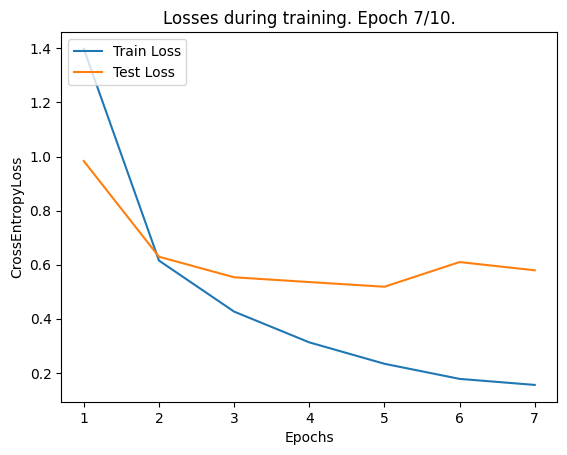

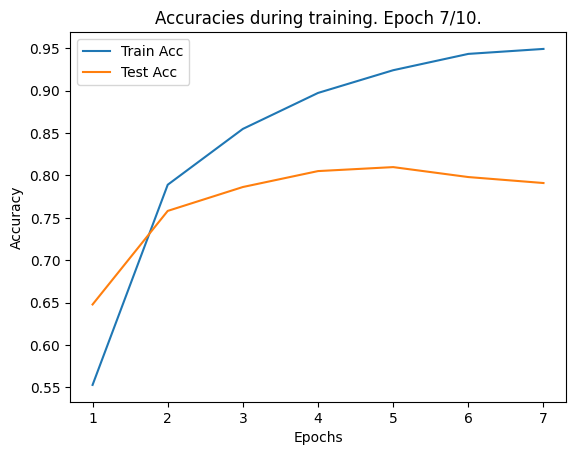

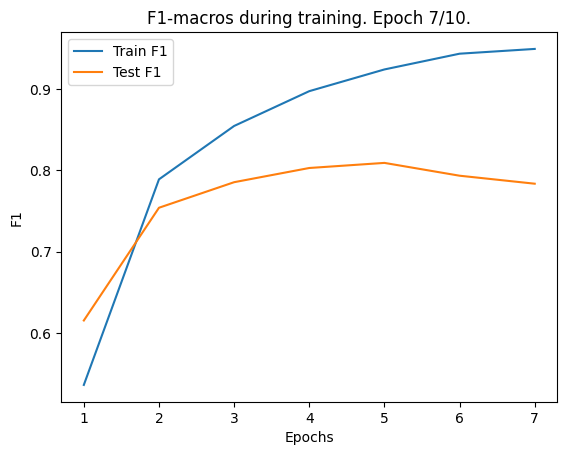

----------
Epoch Time: 0:05
Epoch 8/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.19it/s, Loss=0.114431, Corrects=248/256, Accuracy=96.875%]


Calculating metrics...
train loss: 0.109061, acc: 0.971261, f05_macro: 0.971198, f1_macro: 0.971149
Confusion matrix:
[[432   6   4   4   0   0   0   0]
 [ 13 424   1   4   0   0   2   0]
 [  4   1 427  11   1   1   1   1]
 [  7   3  10 418   0   0   1   2]
 [  1   0   2   0 441   4   0   5]
 [  0   1   2   0   4 437   0   0]
 [  0   1   1   0   0   0 452   0]
 [  1   1   1   1   1   0   0 450]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.26it/s, Loss=0.527417, Corrects=139/170, Accuracy=81.765%]


Calculating metrics...
test loss: 0.550374, acc: 0.816901, f05_macro: 0.816350, f1_macro: 0.812932
Confusion matrix:
[[30 13  3  4  0  1  2  0]
 [ 5 46  0  0  0  0  2  0]
 [ 2  1 33 12  3  0  2  0]
 [ 1  8  2 40  0  0  1  2]
 [ 0  0  3  1 44  3  0  2]
 [ 0  0  0  0  2 51  0  0]
 [ 0  2  0  0  0  0 52  0]
 [ 0  0  0  0  1  0  0 52]]


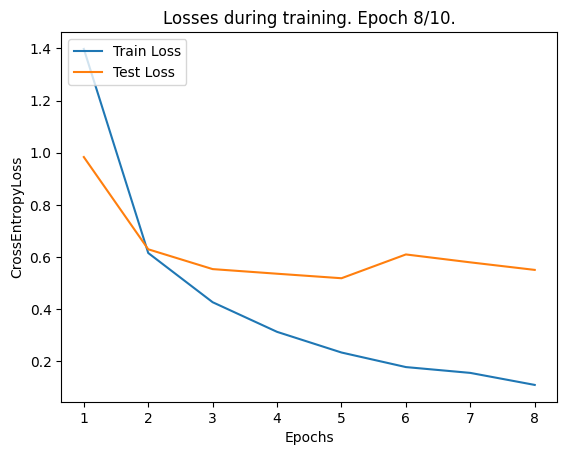

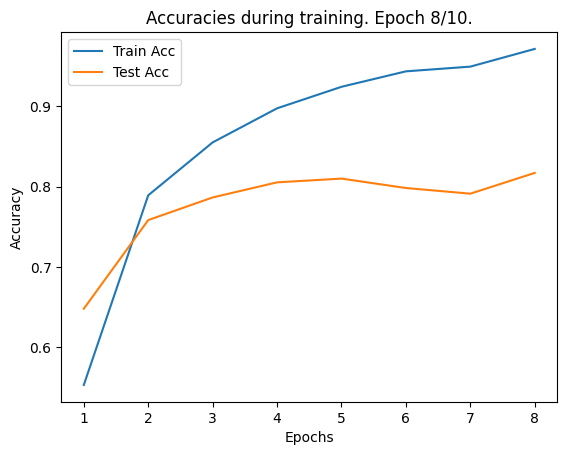

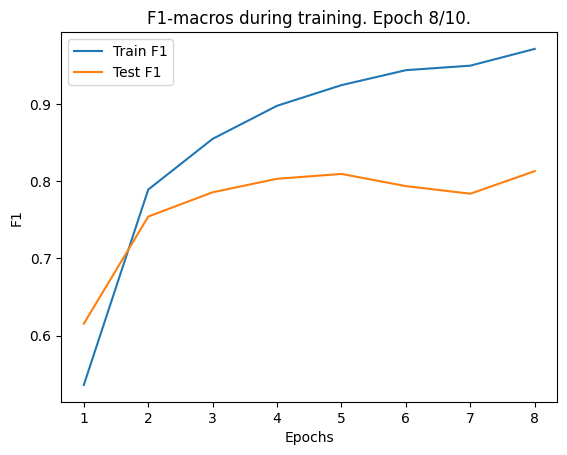

----------
Epoch Time: 0:05
Epoch 9/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.39it/s, Loss=0.047803, Corrects=253/256, Accuracy=98.828%]


Calculating metrics...
train loss: 0.086500, acc: 0.978237, f05_macro: 0.978271, f1_macro: 0.978234
Confusion matrix:
[[434  10   2   0   0   0   0   0]
 [ 12 434   4   1   0   0   0   0]
 [  4   4 426   6   1   1   1   0]
 [  2   4   6 434   0   0   0   1]
 [  0   0   0   0 440   3   0   3]
 [  0   1   1   0   2 451   0   0]
 [  0   1   1   0   0   0 446   0]
 [  2   1   1   1   2   0   0 441]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.26it/s, Loss=0.618035, Corrects=135/170, Accuracy=79.412%]


Calculating metrics...
test loss: 0.569096, acc: 0.826291, f05_macro: 0.828352, f1_macro: 0.824307
Confusion matrix:
[[28 11  8  4  0  1  1  0]
 [ 4 44  2  1  0  0  2  0]
 [ 1  1 42  8  0  0  1  0]
 [ 1  2  7 43  0  0  0  1]
 [ 0  0  3  1 47  0  0  2]
 [ 0  0  0  0  7 46  0  0]
 [ 0  1  2  1  0  0 50  0]
 [ 0  0  0  0  1  0  0 52]]


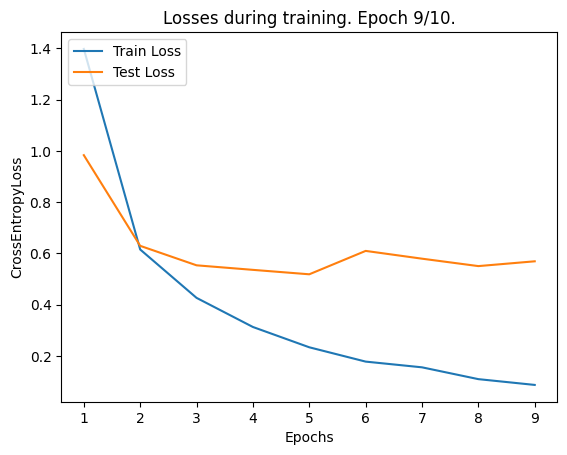

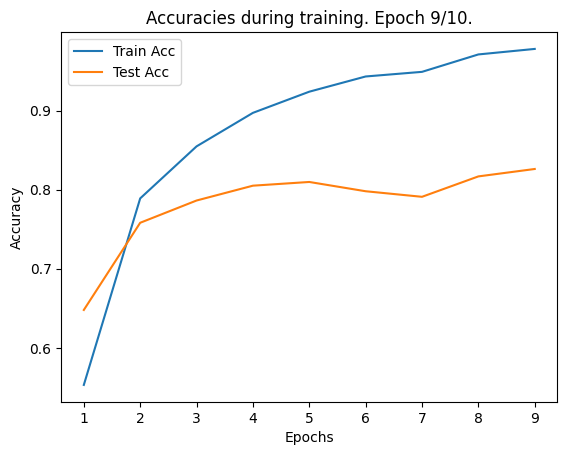

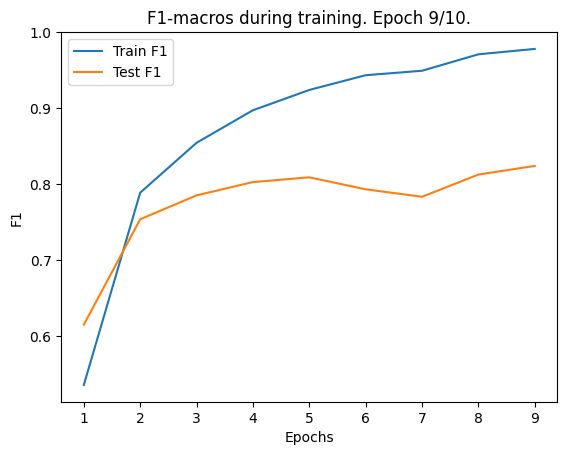

----------
Epoch Time: 0:05
Epoch 10/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:04<00:00,  3.39it/s, Loss=0.052609, Corrects=254/256, Accuracy=99.219%]


Calculating metrics...
train loss: 0.068745, acc: 0.979911, f05_macro: 0.979919, f1_macro: 0.979909
Confusion matrix:
[[430  10   6   2   0   1   0   0]
 [  7 435   2   4   0   0   0   0]
 [  6   2 436   4   2   0   0   0]
 [  0   1   9 435   0   0   1   1]
 [  0   0   1   0 439   2   0   3]
 [  0   0   1   0   5 439   0   0]
 [  0   0   0   0   0   0 452   0]
 [  1   0   0   0   1   0   0 446]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.29it/s, Loss=0.559757, Corrects=140/170, Accuracy=82.353%]


Calculating metrics...
test loss: 0.568062, acc: 0.835681, f05_macro: 0.837696, f1_macro: 0.835835
Confusion matrix:
[[35 10  4  2  0  1  1  0]
 [10 43  0  0  0  0  0  0]
 [ 4  1 42  5  0  0  1  0]
 [ 5  5  5 37  0  0  1  1]
 [ 0  1  3  0 45  2  0  2]
 [ 0  0  0  0  2 51  0  0]
 [ 0  2  1  0  0  0 51  0]
 [ 0  0  0  0  1  0  0 52]]


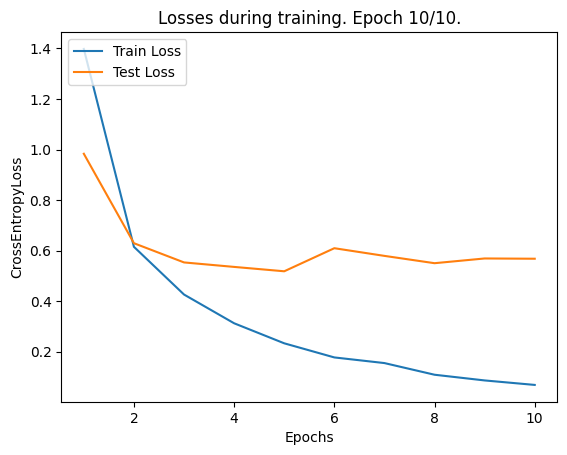

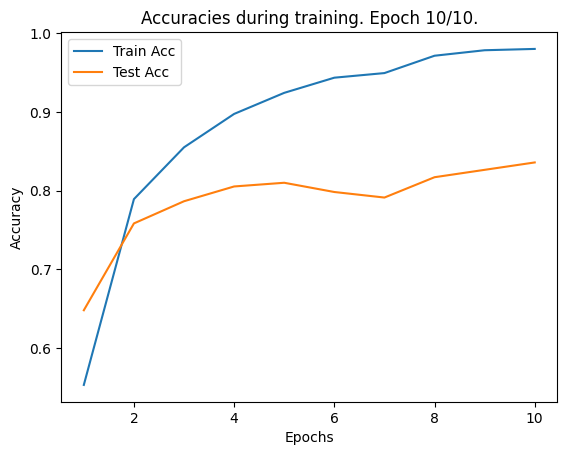

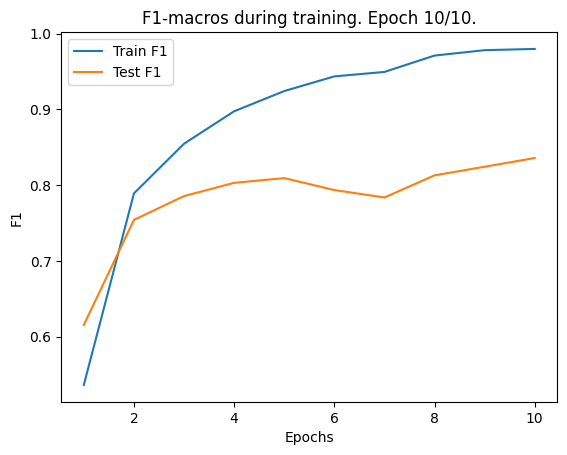

----------
Epoch Time: 0:05
*** Training Completed ***
Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Criterion: CrossEntropyLoss()
Epoch 1/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.64it/s, Loss=1.233235, Corrects=131/256, Accuracy=51.172%]


Calculating metrics...
train loss: 8.227339, acc: 0.301897, f05_macro: 0.282637, f1_macro: 0.286534
Confusion matrix:
[[106  77  50  80  23  14  66  32]
 [ 88  70  53  78  21  21  78  37]
 [ 84  50  64  83  35  29  64  43]
 [ 57  44  63 101  30  30  62  60]
 [ 36  11  34  49  51 138  38  92]
 [ 36  14  32  45  31 209  53  30]
 [ 54  23  33  18  23  17 234  47]
 [ 16  13  14  39  40  30  44 247]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s, Loss=1.018751, Corrects=107/170, Accuracy=62.941%]


Calculating metrics...
test loss: 1.055454, acc: 0.603286, f05_macro: 0.536436, f1_macro: 0.539133
Confusion matrix:
[[45  2  0  4  0  1  1  0]
 [44  3  0  6  0  0  0  0]
 [21  2  0 28  1  0  1  0]
 [13  0  0 34  0  1  3  3]
 [ 1  0  0  3 21 23  0  5]
 [ 1  0  0  0  0 52  0  0]
 [ 1  2  0  1  0  0 50  0]
 [ 0  0  0  0  1  0  0 52]]
----------
Epoch Time: 0:03
Epoch 2/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.58it/s, Loss=0.728744, Corrects=175/256, Accuracy=68.359%]


Calculating metrics...
train loss: 0.928232, acc: 0.620815, f05_macro: 0.613770, f1_macro: 0.615556
Confusion matrix:
[[183 159  37  51   6   1  15   0]
 [134 176  47  52   1   4  34   0]
 [ 64  71 143 126  11   4  26   0]
 [ 43  26  97 223  13   4  22  21]
 [  2   1   7  21 310  84   2  22]
 [  7   5   5   1  60 369   1   0]
 [ 11  11   5   6   1   1 409   0]
 [  4   0   1  12  17   0   3 412]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.02it/s, Loss=0.619345, Corrects=124/170, Accuracy=72.941%]

Calculating metrics...
test loss: 0.676902, acc: 0.720657, f05_macro: 0.722131, f1_macro: 0.706561
Confusion matrix:
[[43  8  0  0  0  1  1  0]
 [36 16  0  1  0  0  0  0]
 [11  2 35  3  1  0  1  0]
 [ 9  0 27 14  0  0  2  2]
 [ 2  0  1  0 44  4  0  2]
 [ 0  0  0  0  2 51  0  0]
 [ 0  2  0  0  0  0 52  0]
 [ 0  0  0  0  1  0  0 52]]


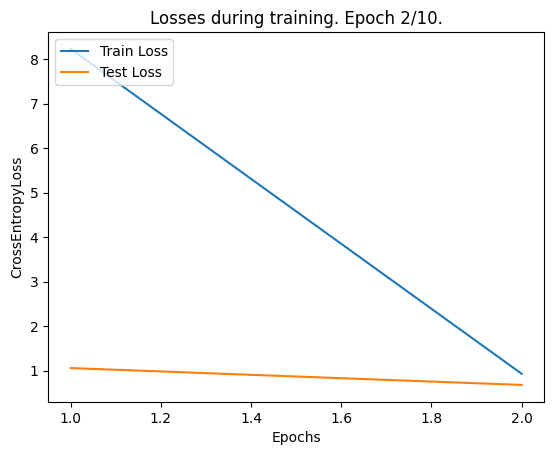

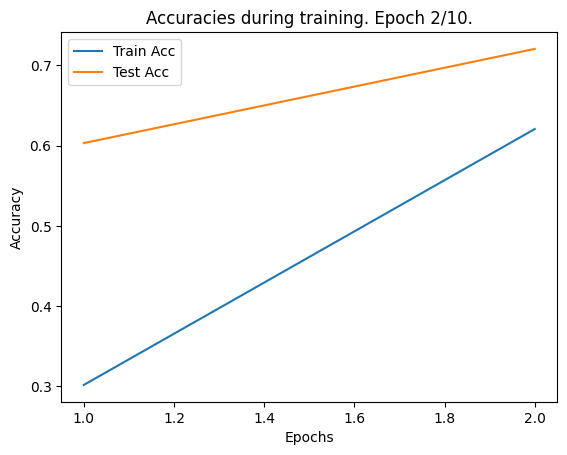

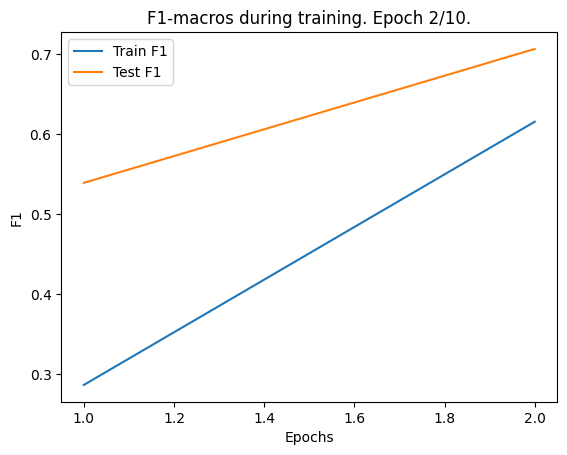

----------
Epoch Time: 0:03
Epoch 3/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.68it/s, Loss=0.743645, Corrects=176/256, Accuracy=68.750%]


Calculating metrics...
train loss: 0.658455, acc: 0.737444, f05_macro: 0.738478, f1_macro: 0.738303
Confusion matrix:
[[259 123  38  17   6   0   5   0]
 [153 252  19  21   0   1   8   1]
 [ 49  42 233  94  10   3  16   4]
 [ 25  24  94 284   2   1   7  11]
 [  1   1  14   5 383  37   0  10]
 [  5   2   5   1  32 400   0   0]
 [  2  10   4   4   0   0 418   0]
 [  0   2   3   9  19   0   1 414]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s, Loss=0.545216, Corrects=134/170, Accuracy=78.824%]

Calculating metrics...
test loss: 0.600995, acc: 0.786385, f05_macro: 0.793384, f1_macro: 0.784809
Confusion matrix:
[[26 25  0  0  0  1  1  0]
 [11 41  0  0  0  0  1  0]
 [ 6  5 39  1  1  0  1  0]
 [ 7  2 14 28  0  0  1  2]
 [ 1  0  2  0 45  3  0  2]
 [ 0  0  0  0  2 51  0  0]
 [ 0  1  0  0  0  0 53  0]
 [ 0  0  0  0  1  0  0 52]]


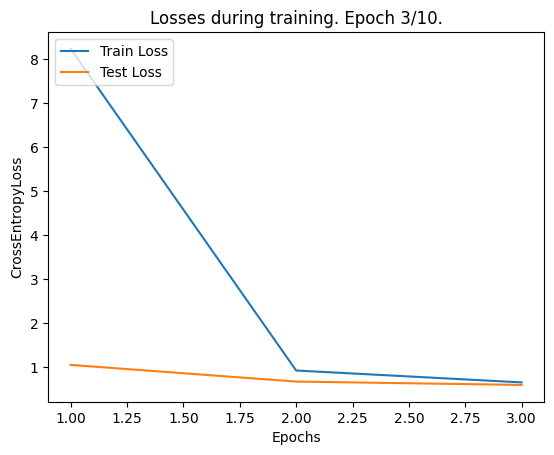

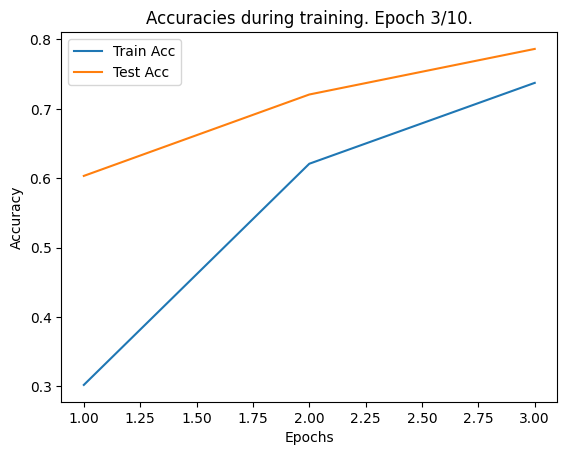

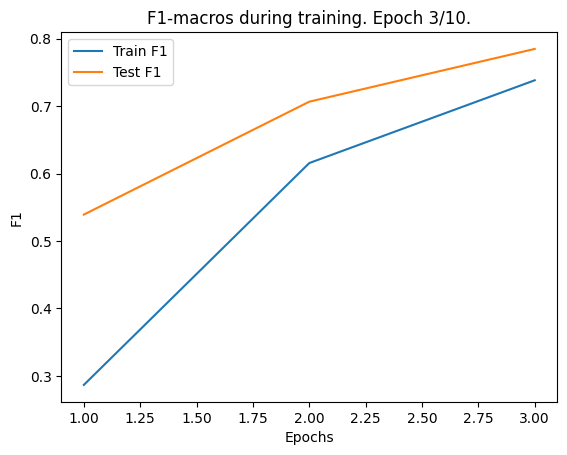

----------
Epoch Time: 0:03
Epoch 4/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.52it/s, Loss=0.611251, Corrects=205/256, Accuracy=80.078%]


Calculating metrics...
train loss: 0.566523, acc: 0.800502, f05_macro: 0.800477, f1_macro: 0.800150
Confusion matrix:
[[305  89  30  11   4   1   3   0]
 [107 305  15  10   0   2   8   1]
 [ 34  28 297  59  10   1  14   3]
 [ 21  22  70 315   5   1   7  10]
 [  3   0  13   3 386  24   0  16]
 [  1   5   4   3  27 401   1   0]
 [  2   7   3   5   0   0 436   0]
 [  1   0   3  13  15   0   0 424]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.96it/s, Loss=0.484081, Corrects=135/170, Accuracy=79.412%]

Calculating metrics...
test loss: 0.521991, acc: 0.798122, f05_macro: 0.801126, f1_macro: 0.797828
Confusion matrix:
[[32 17  2  0  0  1  1  0]
 [17 36  0  0  0  0  0  0]
 [ 4  3 39  6  0  0  1  0]
 [ 4  2  9 36  0  0  1  2]
 [ 1  0  1  1 40  5  0  5]
 [ 0  1  0  0  1 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  0  0  1  0  0 52]]


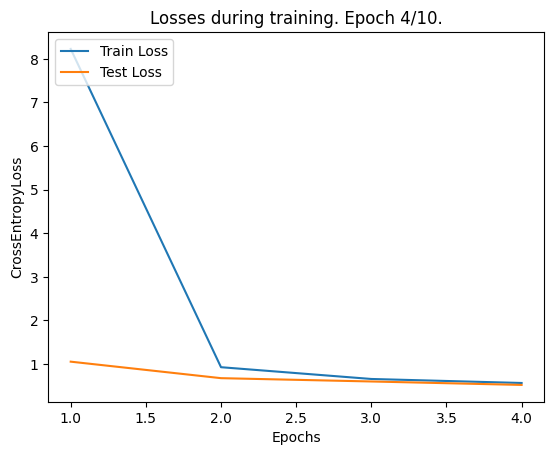

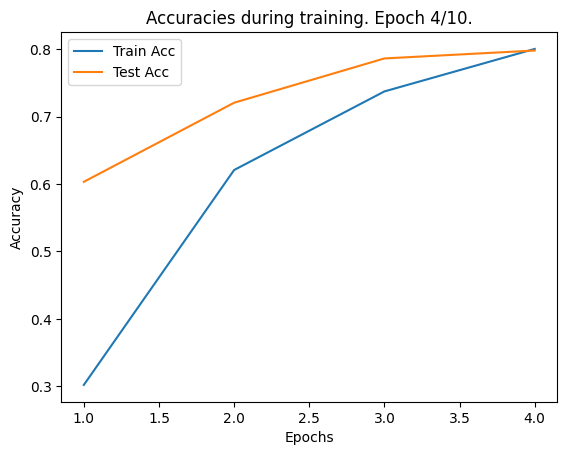

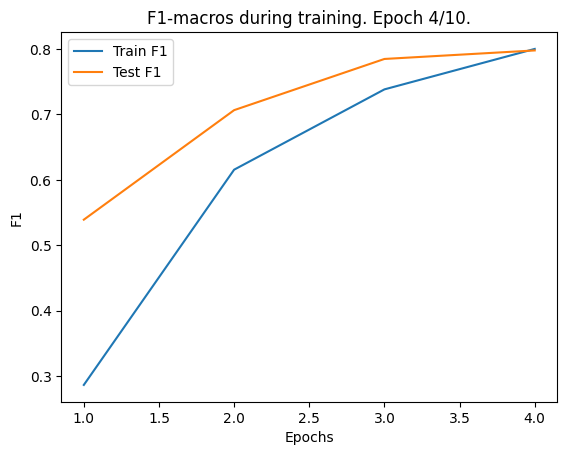

----------
Epoch Time: 0:03
Epoch 5/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  4.75it/s, Loss=0.542923, Corrects=205/256, Accuracy=80.078%]


Calculating metrics...
train loss: 0.493093, acc: 0.814453, f05_macro: 0.814409, f1_macro: 0.814258
Confusion matrix:
[[309  90  27  14   0   0   3   0]
 [ 98 308  11  12   0   2  12   0]
 [ 36  27 297  74   2   1  15   2]
 [ 21  14  77 320   0   0   3  14]
 [  4   0   6   6 408  17   0  13]
 [  4   3   6   1  11 430   0   0]
 [  0   5   3   4   0   0 426   0]
 [  0   1   4   7  14   0   1 421]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s, Loss=0.498633, Corrects=132/170, Accuracy=77.647%]

Calculating metrics...
test loss: 0.535280, acc: 0.798122, f05_macro: 0.805379, f1_macro: 0.794329
Confusion matrix:
[[43  7  1  0  0  1  1  0]
 [27 26  0  0  0  0  0  0]
 [ 3  3 44  2  0  0  1  0]
 [ 6  1 16 27  0  0  1  3]
 [ 0  0  3  0 46  1  0  3]
 [ 0  0  0  0  4 49  0  0]
 [ 1  0  0  0  0  0 53  0]
 [ 0  0  0  0  1  0  0 52]]


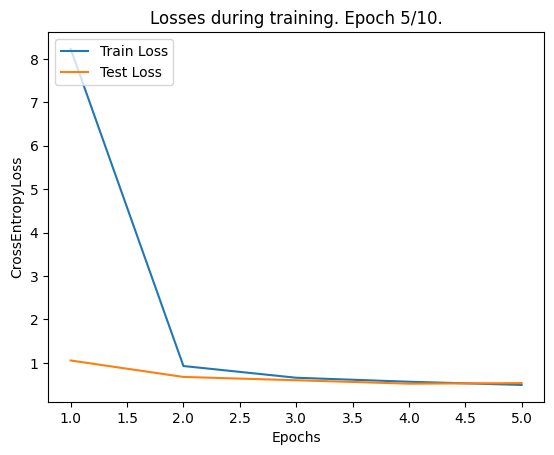

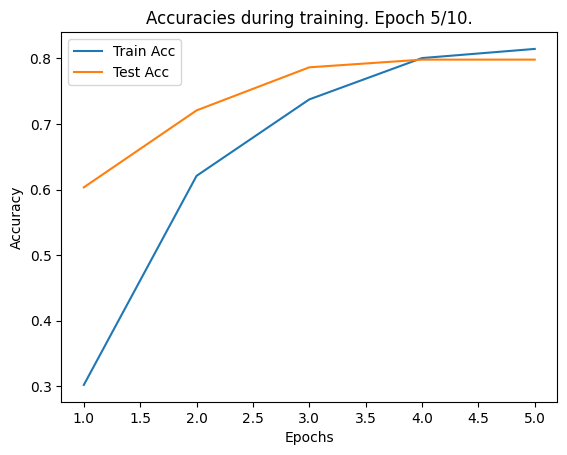

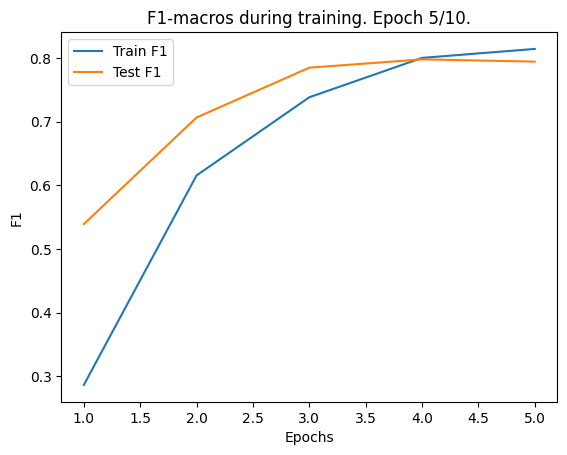

----------
Epoch Time: 0:03
Epoch 6/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.31it/s, Loss=0.535183, Corrects=200/256, Accuracy=78.125%]


Calculating metrics...
train loss: 0.473855, acc: 0.815569, f05_macro: 0.815752, f1_macro: 0.815421
Confusion matrix:
[[308  98  28   9   0   1   3   0]
 [ 99 308  13  13   0   3   9   1]
 [ 33  24 308  66   7   3   8   0]
 [ 27  10  65 324   1   2   2  10]
 [  1   0   9   4 399  21   0  13]
 [  3   4   4   2  21 418   0   0]
 [  0   7  10   3   0   0 426   0]
 [  0   1   1   9  13   0   0 432]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.94it/s, Loss=0.464856, Corrects=140/170, Accuracy=82.353%]

Calculating metrics...
test loss: 0.515989, acc: 0.823944, f05_macro: 0.829864, f1_macro: 0.817030
Confusion matrix:
[[46  3  2  0  0  1  1  0]
 [29 21  2  0  0  0  1  0]
 [ 2  0 45  3  0  0  3  0]
 [ 3  0 13 35  0  0  1  2]
 [ 0  0  3  0 46  1  0  3]
 [ 0  0  0  0  2 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  0  0  0  0  0 53]]


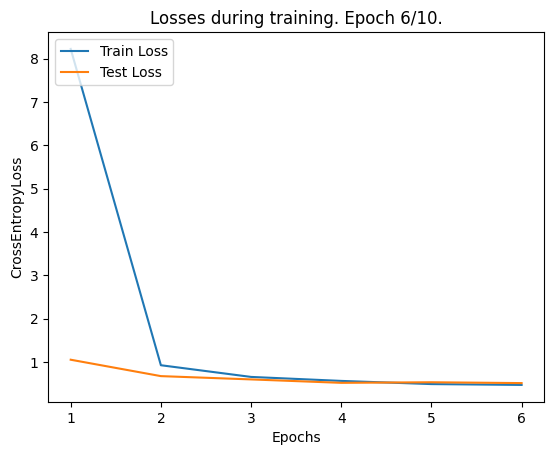

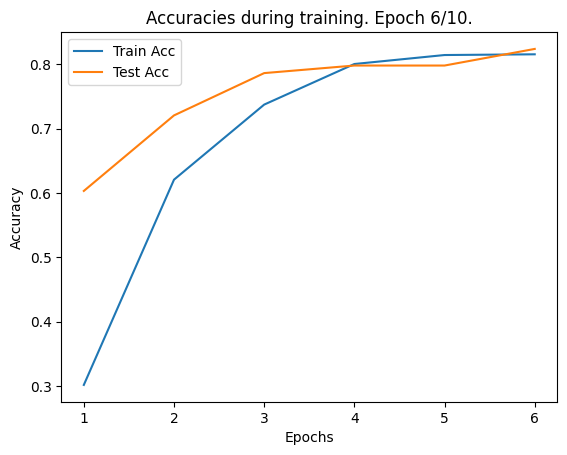

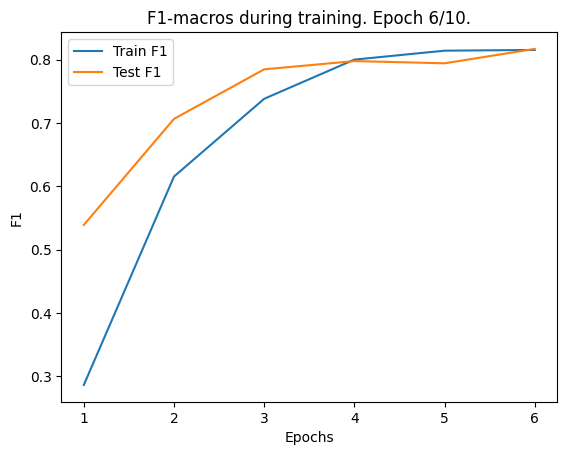

----------
Epoch Time: 0:03
Epoch 7/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.49it/s, Loss=0.363626, Corrects=221/256, Accuracy=86.328%]


Calculating metrics...
train loss: 0.414260, acc: 0.849609, f05_macro: 0.849500, f1_macro: 0.849127
Confusion matrix:
[[349  60  26   9   1   2   2   0]
 [ 98 315  14   7   1   1  11   1]
 [ 36  18 322  50   8   1   8   1]
 [ 12  14  44 361   2   0   2   8]
 [  3   0   9   4 407  20   0   8]
 [  2   2   6   0  18 416   0   0]
 [  0   6   2   2   0   0 434   0]
 [  0   3   1   4  11   0   1 441]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s, Loss=0.432006, Corrects=137/170, Accuracy=80.588%]

Calculating metrics...
test loss: 0.488962, acc: 0.823944, f05_macro: 0.827792, f1_macro: 0.822257
Confusion matrix:
[[39 11  1  0  0  1  1  0]
 [21 31  1  0  0  0  0  0]
 [ 2  2 45  2  0  0  2  0]
 [ 3  1 14 33  0  0  1  2]
 [ 0  0  3  0 46  1  0  3]
 [ 0  0  0  0  3 50  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  0  0  0  0  0 53]]


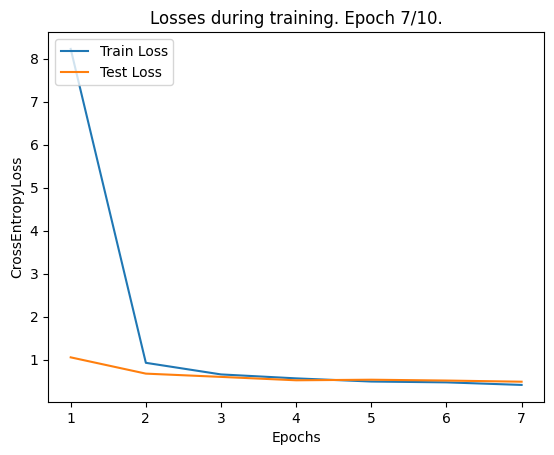

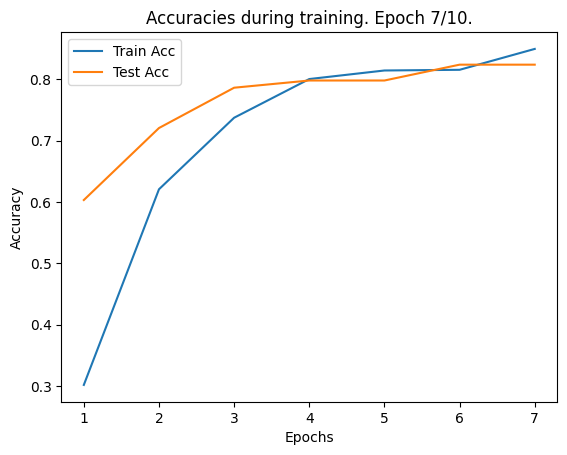

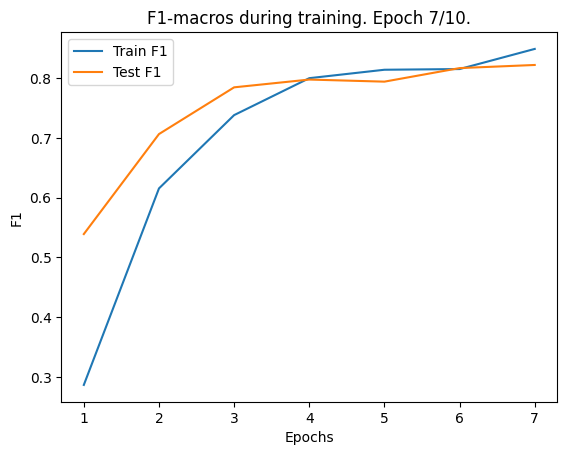

----------
Epoch Time: 0:03
Epoch 8/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.32it/s, Loss=0.439998, Corrects=209/256, Accuracy=81.641%]


Calculating metrics...
train loss: 0.401822, acc: 0.849888, f05_macro: 0.851081, f1_macro: 0.850437
Confusion matrix:
[[338  69  21  10   2   1   3   1]
 [ 90 338  16   9   1   0   7   0]
 [ 21  16 351  41   6   1   5   2]
 [ 23  16  60 339   2   0   4   2]
 [  2   1  10   0 398  20   0  10]
 [  3   3   1   0  24 413   0   0]
 [  0   7   6   2   0   0 435   0]
 [  0   1   3   5  10   0   1 434]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.93it/s, Loss=0.433032, Corrects=138/170, Accuracy=81.176%]

Calculating metrics...
test loss: 0.496258, acc: 0.814554, f05_macro: 0.814384, f1_macro: 0.811569
Confusion matrix:
[[25 24  1  1  0  1  1  0]
 [11 41  0  0  0  0  1  0]
 [ 1  1 41  7  0  0  3  0]
 [ 2  4  6 39  0  0  1  2]
 [ 0  0  1  0 48  1  0  3]
 [ 0  1  0  0  5 47  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  0  0  1  0  0 52]]


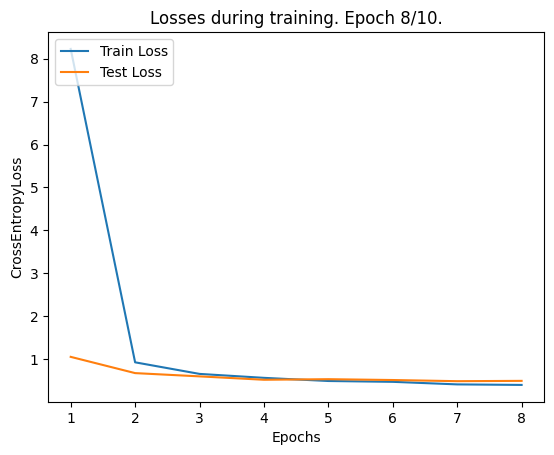

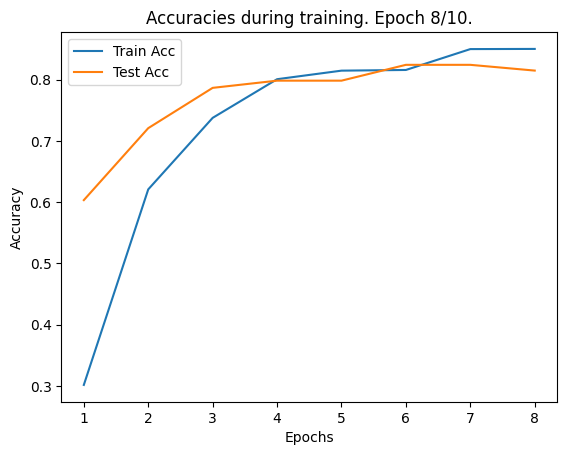

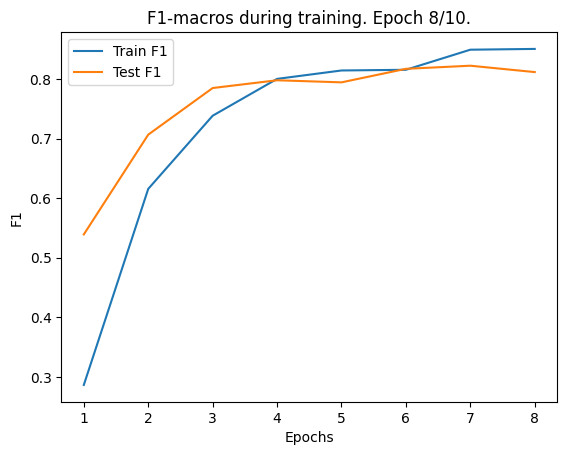

----------
Epoch Time: 0:03
Epoch 9/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.51it/s, Loss=0.341668, Corrects=219/256, Accuracy=85.547%]


Calculating metrics...
train loss: 0.369653, acc: 0.859654, f05_macro: 0.861352, f1_macro: 0.860606
Confusion matrix:
[[366  63  18   6   0   0   1   0]
 [ 90 322  14  11   0   2   9   0]
 [ 35  18 359  38   2   1   5   0]
 [ 16  20  45 347   3   1   3   8]
 [  1   2  10   1 405  17   0   8]
 [  2   2   2   2  17 427   0   0]
 [  1   3   3   5   0   0 426   0]
 [  0   1   4   6   7   0   0 429]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.98it/s, Loss=0.409803, Corrects=141/170, Accuracy=82.941%]

Calculating metrics...
test loss: 0.465143, acc: 0.835681, f05_macro: 0.834653, f1_macro: 0.833050
Confusion matrix:
[[29 19  2  1  0  1  1  0]
 [10 42  0  1  0  0  0  0]
 [ 0  2 40  9  0  0  2  0]
 [ 1  2  7 41  0  0  1  2]
 [ 0  0  1  0 47  2  0  3]
 [ 0  1  0  0  1 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  0  0  1  0  0 52]]


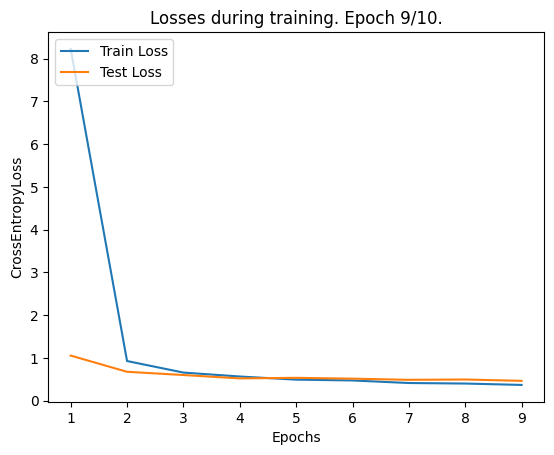

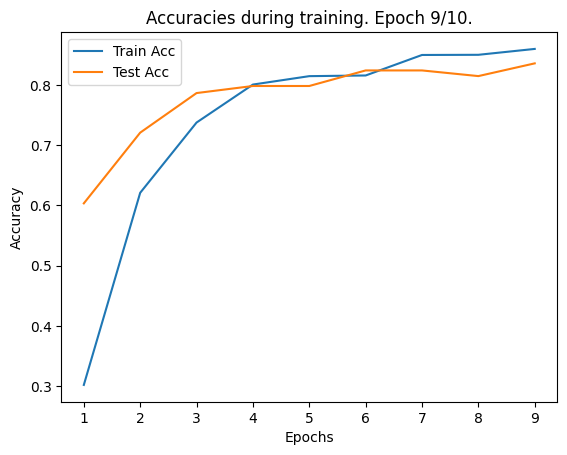

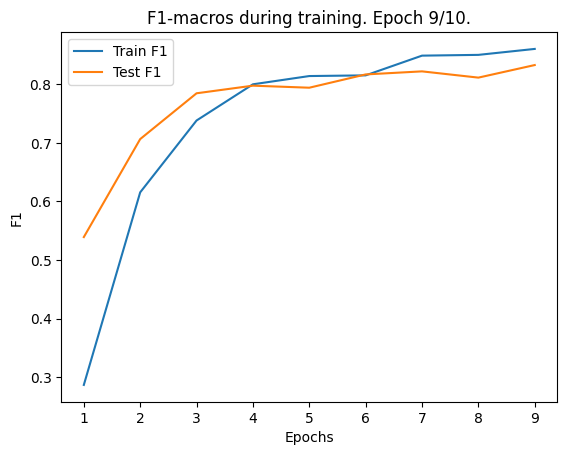

----------
Epoch Time: 0:03
Epoch 10/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.50it/s, Loss=0.308244, Corrects=232/256, Accuracy=90.625%]


Calculating metrics...
train loss: 0.341354, acc: 0.869978, f05_macro: 0.870958, f1_macro: 0.870644
Confusion matrix:
[[346  83  14   7   0   1   2   0]
 [ 66 359   8   9   0   1   6   0]
 [ 20  19 354  44   5   3   6   0]
 [ 10  17  56 358   0   0   3   4]
 [  2   0   6   2 416  13   0  10]
 [  3   2   2   0  17 418   0   0]
 [  1   0   5   3   0   0 441   0]
 [  0   0   5   4   7   0   0 426]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  2.97it/s, Loss=0.362817, Corrects=141/170, Accuracy=82.941%]

Calculating metrics...
test loss: 0.444806, acc: 0.845070, f05_macro: 0.847579, f1_macro: 0.843459
Confusion matrix:
[[43  7  1  0  0  1  1  0]
 [17 35  0  0  0  0  1  0]
 [ 2  3 44  3  0  0  1  0]
 [ 4  1 11 35  0  0  1  2]
 [ 0  0  1  0 45  4  0  3]
 [ 0  1  0  0  1 51  0  0]
 [ 0  0  0  0  0  0 54  0]
 [ 0  0  0  0  0  0  0 53]]


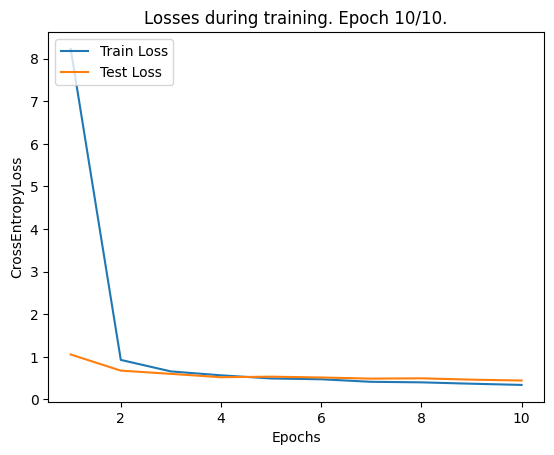

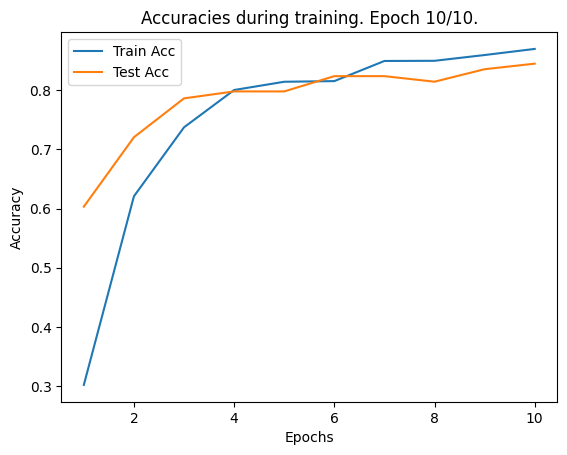

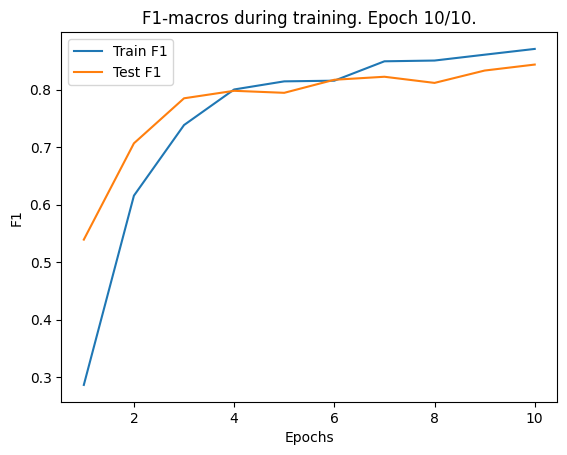

----------
Epoch Time: 0:03
*** Training Completed ***
Training model with params:
Optim: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
Criterion: CrossEntropyLoss()
Epoch 1/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.85it/s, Loss=1.387578, Corrects=119/256, Accuracy=46.484%]


Calculating metrics...
train loss: 5.330057, acc: 0.315848, f05_macro: 0.297608, f1_macro: 0.298807
Confusion matrix:
[[107  79  24  73  37  12  96  21]
 [ 83 100  20  40  42  24 119  18]
 [ 61  51  22 110  62  21  83  33]
 [ 43  32  38 136  59  33  57  55]
 [  4  16   6  76 145  51  10 136]
 [ 17  32   5  63 102 128  39  65]
 [ 35  81  14  37  35  15 220  15]
 [  6   5   2  52  78  21   8 274]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s, Loss=0.885642, Corrects=111/170, Accuracy=65.294%]


Calculating metrics...
test loss: 0.943357, acc: 0.636150, f05_macro: 0.610842, f1_macro: 0.602821
Confusion matrix:
[[39  9  2  0  0  1  2  0]
 [26 16  2  0  0  1  8  0]
 [11  1 31  1  6  0  3  0]
 [ 6  0 25  5 12  1  2  3]
 [ 0  0  3  0 44  0  0  6]
 [ 0  2  0  0 16 35  0  0]
 [ 1  1  1  0  0  0 51  0]
 [ 0  0  0  0  1  2  0 50]]
----------
Epoch Time: 0:08
Epoch 2/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.80it/s, Loss=0.866551, Corrects=168/256, Accuracy=65.625%]


Calculating metrics...
train loss: 0.869034, acc: 0.664342, f05_macro: 0.660370, f1_macro: 0.660815
Confusion matrix:
[[294  96  37  12   0   1   9   1]
 [137 212  50   9   1   4  34   1]
 [ 59  39 206 106   7   5  24   0]
 [ 37  11 130 198  25   5   9  35]
 [  4   0  12  22 308  59   0  43]
 [  6  12   7   3  49 371   0   2]
 [  5  29   7   5   0   0 396   0]
 [  0   3   3   4  38   5   1 396]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s, Loss=0.620804, Corrects=125/170, Accuracy=73.529%]

Calculating metrics...
test loss: 0.679057, acc: 0.741784, f05_macro: 0.737835, f1_macro: 0.732657
Confusion matrix:
[[42  7  1  1  0  1  1  0]
 [27 16  7  1  0  0  2  0]
 [ 2  2 35 10  2  0  2  0]
 [ 0  0 19 30  4  0  1  0]
 [ 0  0  2  2 47  0  0  2]
 [ 0  0  0  0  8 45  0  0]
 [ 0  0  1  1  0  0 52  0]
 [ 0  0  0  0  3  1  0 49]]


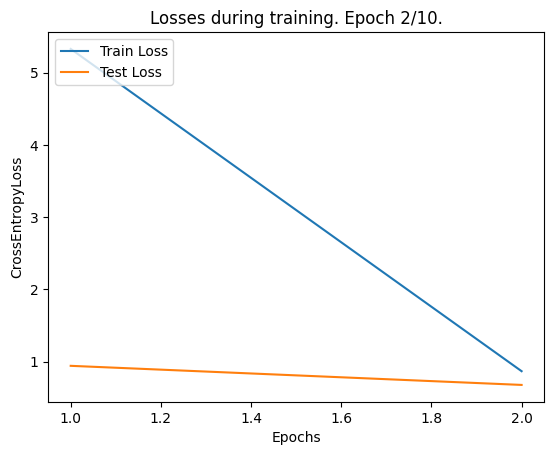

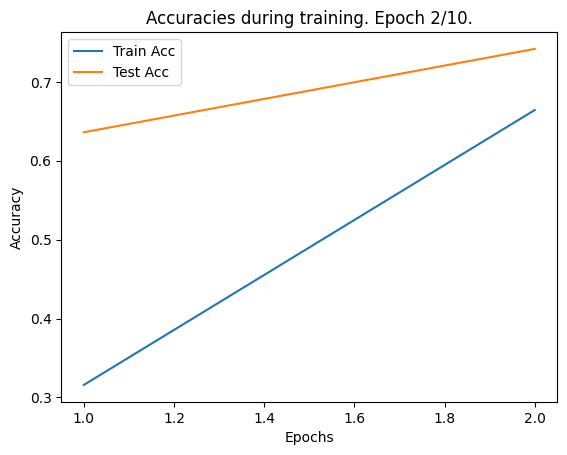

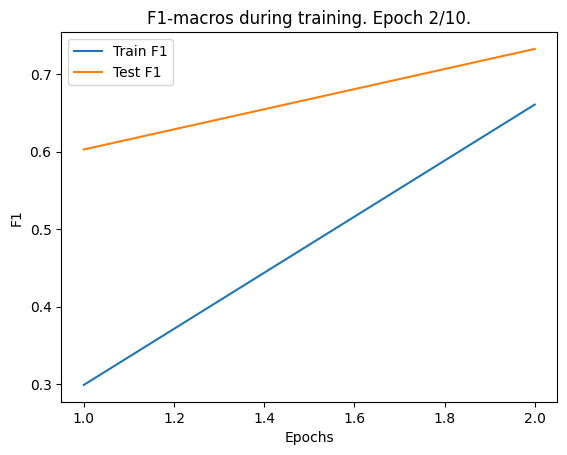

----------
Epoch Time: 0:09
Epoch 3/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.80it/s, Loss=0.519787, Corrects=205/256, Accuracy=80.078%]


Calculating metrics...
train loss: 0.579316, acc: 0.783761, f05_macro: 0.783775, f1_macro: 0.783465
Confusion matrix:
[[317  86  22  11   1   1   4   0]
 [102 286  25  12   1   5  18   0]
 [ 37  36 268  88   5   3   5   1]
 [ 21  15  89 307   6   3   0  12]
 [  1   0  10  10 381  29   0  16]
 [  4   5   3   4  20 411   0   0]
 [  1   9   6   3   0   0 427   0]
 [  2   0   2  19  20   2   0 412]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s, Loss=0.564305, Corrects=131/170, Accuracy=77.059%]

Calculating metrics...
test loss: 0.615649, acc: 0.791080, f05_macro: 0.787547, f1_macro: 0.786158
Confusion matrix:
[[37 13  1  0  0  1  1  0]
 [12 39  1  0  0  0  1  0]
 [ 1  3 37  8  2  0  2  0]
 [ 1  2 16 26  5  0  1  3]
 [ 0  0  2  0 46  0  0  5]
 [ 0  0  0  0  6 47  0  0]
 [ 0  0  0  1  0  0 53  0]
 [ 0  0  0  0  1  0  0 52]]


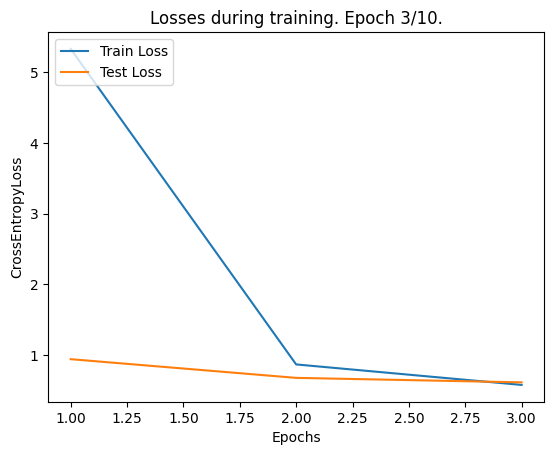

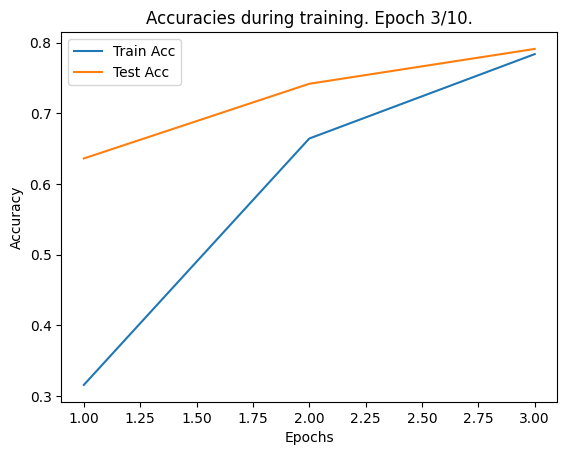

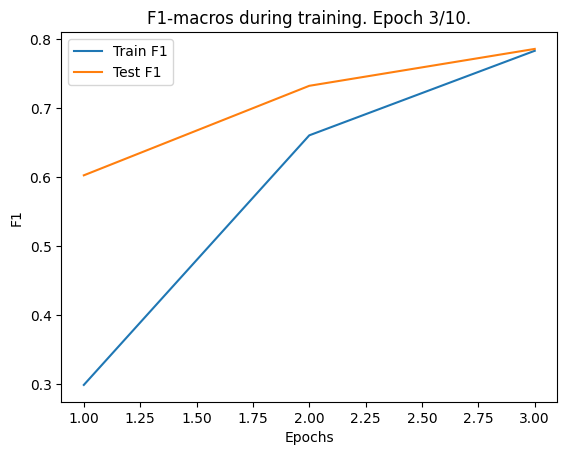

----------
Epoch Time: 0:09
Epoch 4/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.81it/s, Loss=0.450601, Corrects=220/256, Accuracy=85.938%]


Calculating metrics...
train loss: 0.460964, acc: 0.834263, f05_macro: 0.833592, f1_macro: 0.833417
Confusion matrix:
[[351  73  17   4   0   1   0   0]
 [ 83 317  18   5   0   1  11   0]
 [ 26  30 306  65   7   3  10   0]
 [ 13   9  80 329   2   1   3  13]
 [  0   1   4   6 413  17   0  16]
 [  1   4   4   3  19 416   0   0]
 [  0  14   4   3   0   0 431   0]
 [  1   1   1   7  12   1   0 427]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s, Loss=0.458554, Corrects=139/170, Accuracy=81.765%]

Calculating metrics...
test loss: 0.541478, acc: 0.807512, f05_macro: 0.806721, f1_macro: 0.805558
Confusion matrix:
[[39  9  2  1  0  1  1  0]
 [15 34  4  0  0  0  0  0]
 [ 1  2 41  7  1  0  1  0]
 [ 2  2 14 32  1  0  1  2]
 [ 0  0  2  1 45  2  0  3]
 [ 0  0  0  0  4 49  0  0]
 [ 0  0  0  1  0  0 53  0]
 [ 0  0  0  0  2  0  0 51]]


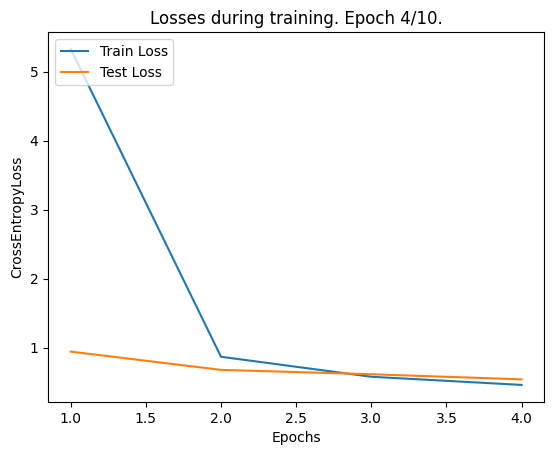

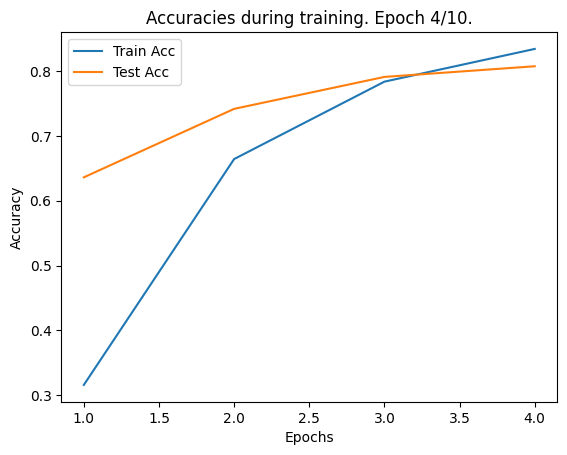

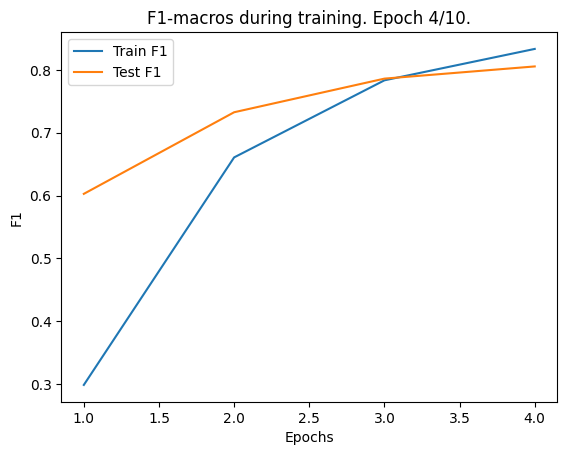

----------
Epoch Time: 0:09
Epoch 5/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.79it/s, Loss=0.306148, Corrects=230/256, Accuracy=89.844%]


Calculating metrics...
train loss: 0.377581, acc: 0.863281, f05_macro: 0.863119, f1_macro: 0.862896
Confusion matrix:
[[364  65  10   7   0   0   0   0]
 [ 73 334  21  11   0   2  12   0]
 [ 27  24 317  59   1   2   2   1]
 [ 11   7  61 364   3   1   1   6]
 [  0   0   4   6 420  11   0   9]
 [  1   3   3   3  10 435   0   0]
 [  0   6   5   0   0   0 445   0]
 [  0   1   1   9  11   0   0 415]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.55it/s, Loss=0.433334, Corrects=134/170, Accuracy=78.824%]

Calculating metrics...
test loss: 0.509975, acc: 0.800469, f05_macro: 0.802195, f1_macro: 0.799896
Confusion matrix:
[[41  8  2  0  0  1  1  0]
 [16 31  5  0  0  0  1  0]
 [ 1  3 39  9  0  0  1  0]
 [ 1  2 14 34  1  0  1  1]
 [ 0  0  3  0 46  2  0  2]
 [ 0  0  0  0  3 50  0  0]
 [ 0  1  2  0  0  0 51  0]
 [ 0  0  0  0  4  0  0 49]]


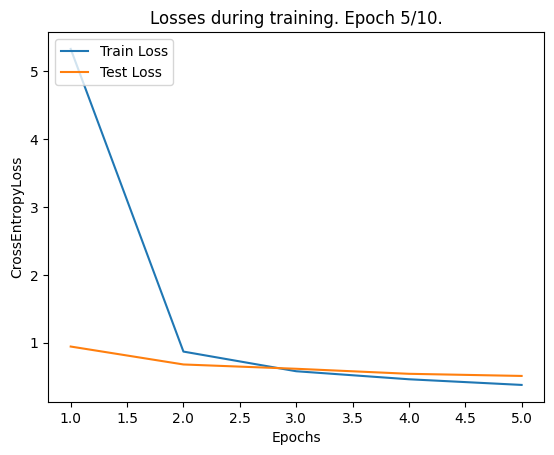

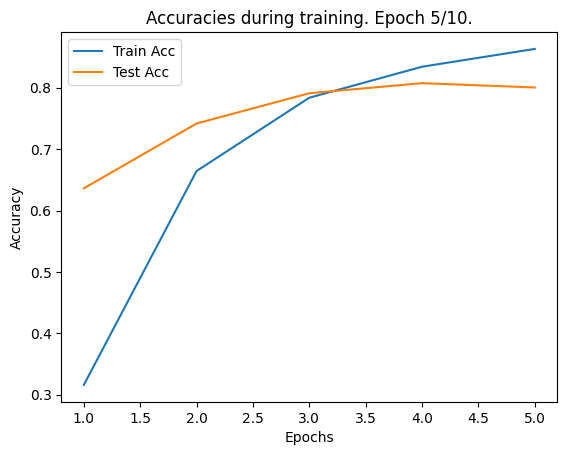

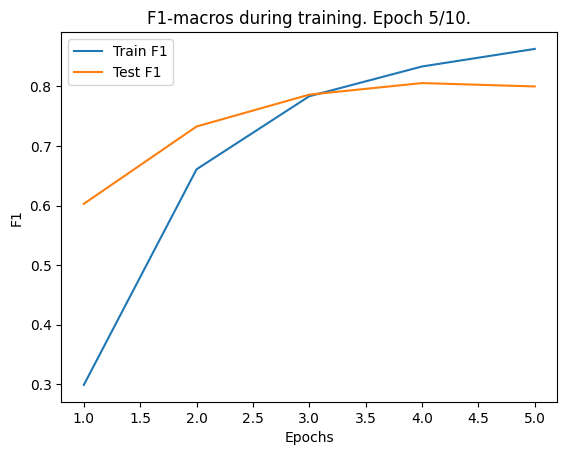

----------
Epoch Time: 0:09
Epoch 6/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.82it/s, Loss=0.370358, Corrects=220/256, Accuracy=85.938%]


Calculating metrics...
train loss: 0.305259, acc: 0.886998, f05_macro: 0.887916, f1_macro: 0.887620
Confusion matrix:
[[375  65  12   1   0   0   1   0]
 [ 57 358  15   7   0   4   8   0]
 [ 14  26 355  40   3   3   3   0]
 [  8   3  49 384   4   0   2   4]
 [  1   0   3   1 427  11   0   4]
 [  0   4   3   2  10 427   0   0]
 [  0  13   3   0   0   1 424   0]
 [  0   1   0   9  10   0   0 429]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s, Loss=0.613058, Corrects=129/170, Accuracy=75.882%]

Calculating metrics...
test loss: 0.597841, acc: 0.784038, f05_macro: 0.782720, f1_macro: 0.769434
Confusion matrix:
[[47  3  0  1  0  1  1  0]
 [32 14  3  3  0  0  1  0]
 [ 2  1 28 20  0  0  2  0]
 [ 3  0  3 47  0  0  0  1]
 [ 0  0  1  3 45  1  0  3]
 [ 0  0  0  0  2 51  0  0]
 [ 0  0  0  1  0  0 53  0]
 [ 0  0  0  1  3  0  0 49]]


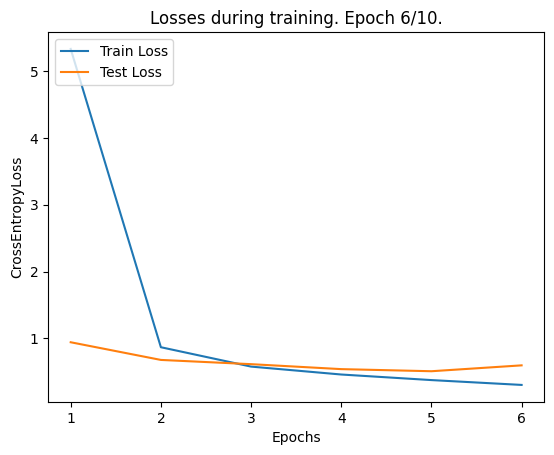

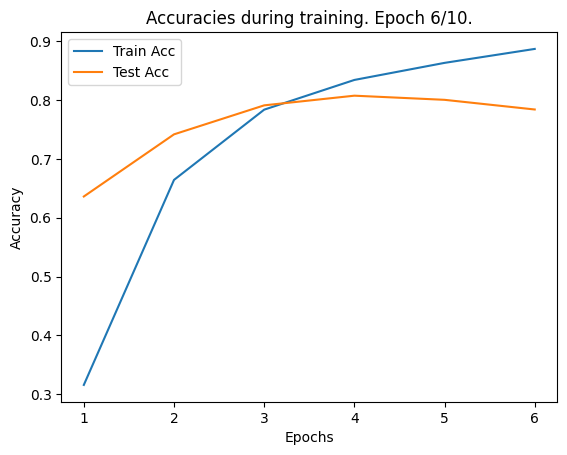

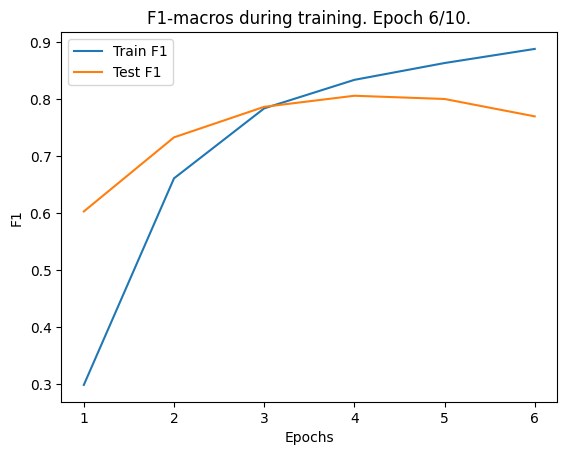

----------
Epoch Time: 0:09
Epoch 7/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.86it/s, Loss=0.294509, Corrects=228/256, Accuracy=89.062%]


Calculating metrics...
train loss: 0.284443, acc: 0.904018, f05_macro: 0.904941, f1_macro: 0.904708
Confusion matrix:
[[380  57   6   4   0   0   1   0]
 [ 53 387   9   6   0   1   4   0]
 [ 17  17 370  39   2   2   3   0]
 [  6   9  46 378   1   0   1   4]
 [  0   0   3   2 432   6   0   8]
 [  1   4   4   1   4 421   1   0]
 [  0   1   4   0   0   0 441   0]
 [  0   1   1   7   8   0   0 431]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s, Loss=0.497746, Corrects=140/170, Accuracy=82.353%]

Calculating metrics...
test loss: 0.572650, acc: 0.816901, f05_macro: 0.820714, f1_macro: 0.814960
Confusion matrix:
[[39  9  3  0  0  1  1  0]
 [15 33  5  0  0  0  0  0]
 [ 1  3 44  4  0  0  1  0]
 [ 0  2 15 33  1  0  1  2]
 [ 0  0  3  0 41  2  0  7]
 [ 0  0  0  0  1 52  0  0]
 [ 0  0  1  0  0  0 53  0]
 [ 0  0  0  0  0  0  0 53]]


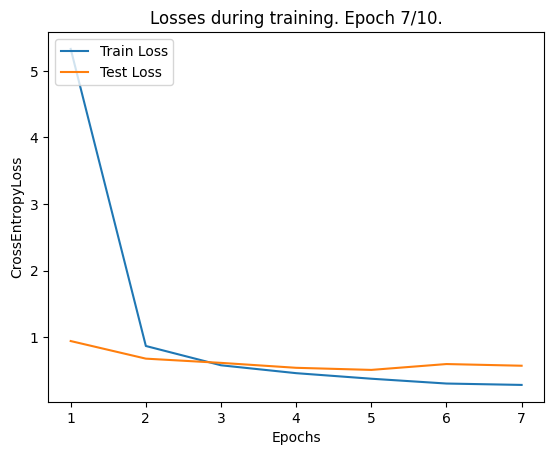

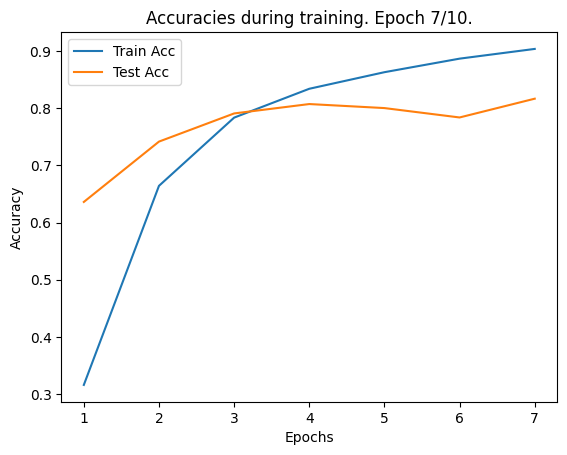

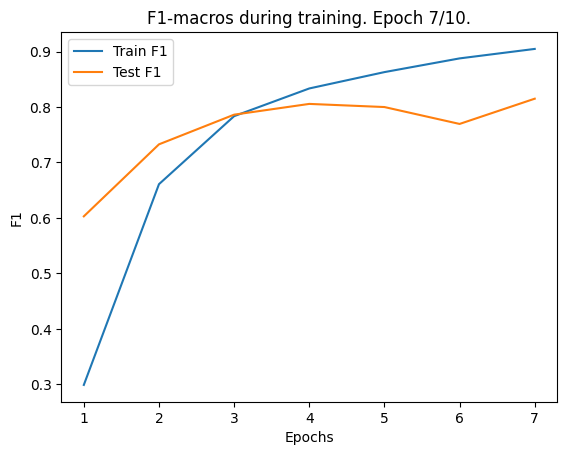

----------
Epoch Time: 0:09
Epoch 8/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.83it/s, Loss=0.171825, Corrects=241/256, Accuracy=94.141%]


Calculating metrics...
train loss: 0.227786, acc: 0.916295, f05_macro: 0.916754, f1_macro: 0.916581
Confusion matrix:
[[387  52   8   3   1   0   1   0]
 [ 43 392   8   1   0   0   4   0]
 [ 16  11 380  33   3   0   5   0]
 [  6   4  36 395   2   0   0   3]
 [  0   0   7   1 424   7   0   8]
 [  0   3   1   2   5 434   0   0]
 [  0   5   2   1   0   0 436   0]
 [  0   1   1   6  10   0   0 436]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s, Loss=0.486632, Corrects=143/170, Accuracy=84.118%]

Calculating metrics...
test loss: 0.565549, acc: 0.830986, f05_macro: 0.835287, f1_macro: 0.831144
Confusion matrix:
[[34 13  4  0  0  1  1  0]
 [ 5 47  1  0  0  0  0  0]
 [ 1  3 38 10  0  0  1  0]
 [ 0  2 14 36  1  0  0  1]
 [ 0  0  3  1 45  2  0  2]
 [ 0  0  0  0  0 53  0  0]
 [ 0  0  3  0  0  0 51  0]
 [ 0  0  0  1  1  1  0 50]]


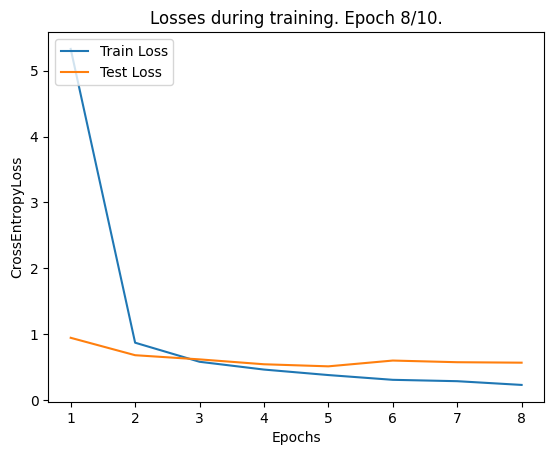

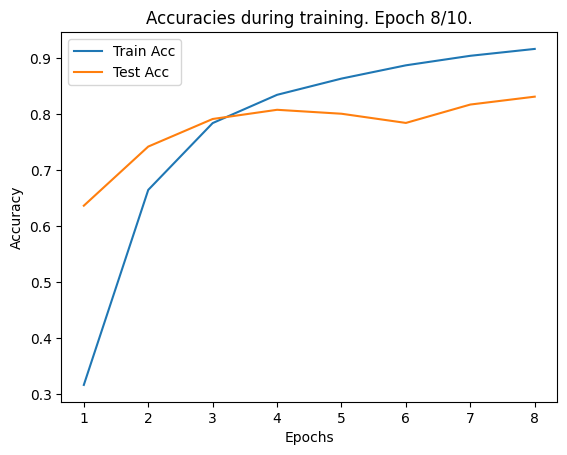

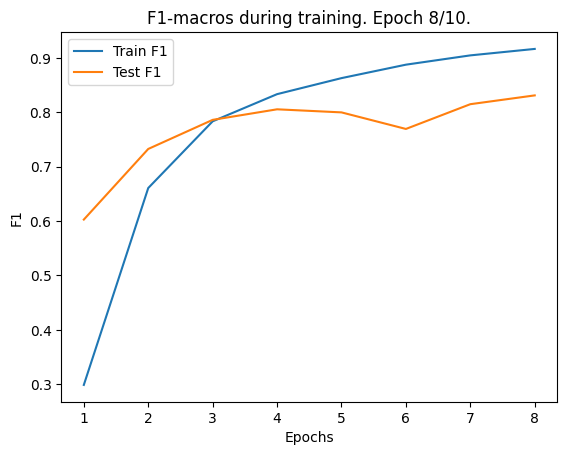

----------
Epoch Time: 0:09
Epoch 9/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.81it/s, Loss=0.237660, Corrects=237/256, Accuracy=92.578%]


Calculating metrics...
train loss: 0.204615, acc: 0.923549, f05_macro: 0.923554, f1_macro: 0.923494
Confusion matrix:
[[387  51   8   3   0   0   0   0]
 [ 39 384  10   4   0   3   6   0]
 [ 16   9 390  23   2   2   1   0]
 [  7   5  22 412   1   0   1   4]
 [  0   0   1   3 426  14   0   5]
 [  1   0   0   1  12 427   0   0]
 [  0   5   3   0   0   0 445   0]
 [  0   1   1   5   4   1   0 439]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s, Loss=0.463676, Corrects=143/170, Accuracy=84.118%]

Calculating metrics...
test loss: 0.537644, acc: 0.826291, f05_macro: 0.826435, f1_macro: 0.824496
Confusion matrix:
[[33 16  2  0  0  1  1  0]
 [ 6 46  1  0  0  0  0  0]
 [ 1  3 36 12  0  0  1  0]
 [ 1  2 10 39  1  0  0  1]
 [ 0  0  1  0 45  2  0  5]
 [ 0  0  0  0  3 50  0  0]
 [ 0  0  2  0  0  0 52  0]
 [ 0  0  0  0  1  1  0 51]]


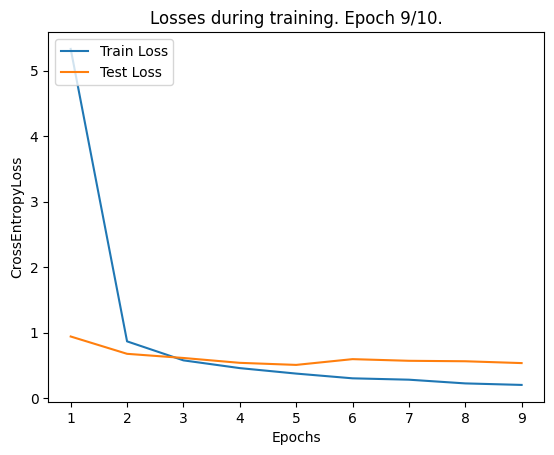

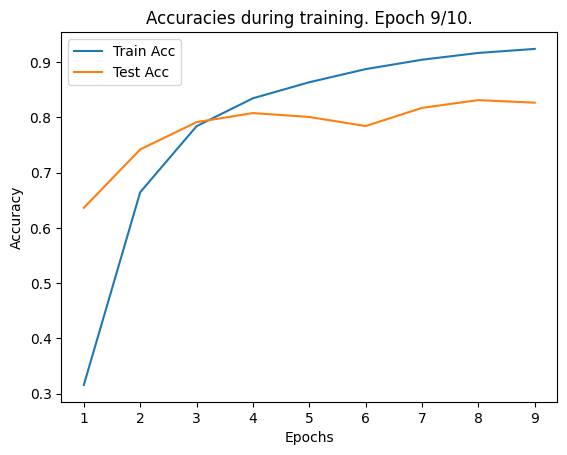

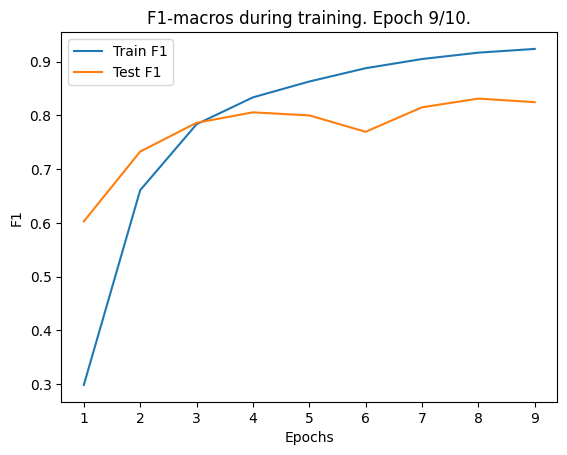

----------
Epoch Time: 0:09
Epoch 10/10
----------
--- Cur phase: train


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:07<00:00,  1.81it/s, Loss=0.165431, Corrects=241/256, Accuracy=94.141%]


Calculating metrics...
train loss: 0.193828, acc: 0.931920, f05_macro: 0.931939, f1_macro: 0.931903
Confusion matrix:
[[402  34   7   3   0   1   0   0]
 [ 36 399   5   2   0   1   9   0]
 [  9  10 395  25   1   2   3   0]
 [  2   2  27 405   0   0   3   4]
 [  0   0   3   0 437   8   0   6]
 [  1   2   2   1  10 433   0   0]
 [  0   5   3   1   0   1 439   0]
 [  1   1   3   4   5   1   0 430]]
--- Cur phase: test


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.56it/s, Loss=0.482198, Corrects=143/170, Accuracy=84.118%]

Calculating metrics...
test loss: 0.569398, acc: 0.838028, f05_macro: 0.836114, f1_macro: 0.835810
Confusion matrix:
[[36 13  2  0  0  1  1  0]
 [ 8 43  2  0  0  0  0  0]
 [ 1  2 37 11  0  0  2  0]
 [ 1  2 10 37  1  0  1  2]
 [ 0  0  1  0 46  3  0  3]
 [ 0  0  0  0  0 53  0  0]
 [ 0  0  0  1  0  0 53  0]
 [ 0  0  0  0  1  0  0 52]]


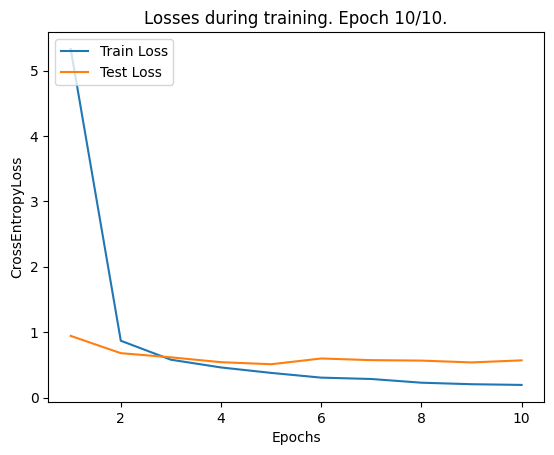

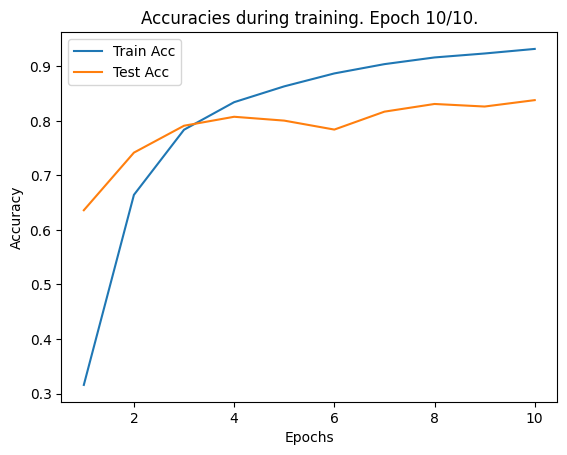

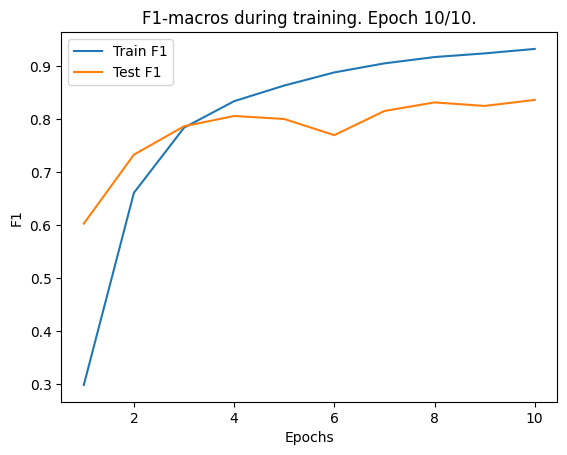

----------
Epoch Time: 0:09
*** Training Completed ***


In [28]:
from torch import optim

for name in list(net_models.keys()):
    model = net_models[name]

    learning_rate = 1e-3
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    num_epochs = 10

    saved_epoch_losses, saved_epoch_accuracies, saved_epoch_f1_macros = train_model(name, dataloaders, num_epochs)

    model_ckpt_path = f"{name}_trained.pth"
    torch.save(model.state_dict(), model_ckpt_path)

### Тестируем обученные модели

In [29]:
def load_random_image(image_dir):
    all_images = os.listdir(image_dir)
    random_image = random.choice(all_images)
    image_path = os.path.join(image_dir, random_image)
    image = Image.open(image_path)
    return image, random_image


def predict_cls(image, model):
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)  # Добавляем дополнительную размерность для batch

    with torch.no_grad():
        output = model(input_batch)

    _, predicted_idx = torch.max(output, 1)

    return predicted_idx.item()

In [30]:
# Трансформации для тестового изображения
preprocess = T.Compose([
    T.Resize(224),  # Изменение размера изображения
    T.ToTensor(),  # Преобразование в тензор
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Нормализация
])

In [31]:
def test_one_image(name, model):
    image_dir = './dataset/test'

    image, image_name = load_random_image(image_dir)

    plt.imshow(image)
    plt.title(f"Model: {name}, image: {image_name}")
    plt.axis('off')
    plt.show()

    model_ckpt_path = f"{name}_trained.pth"
    model.load_state_dict(torch.load(model_ckpt_path, map_location=torch.device('cpu')))
    predicted_class_idx = predict_cls(image, model)
    print(f'Predicted class: {classes[predicted_class_idx]}')

In [32]:
net_models = {}
net_models['resnet'] = get_resnet(num_classes=len(classes))
net_models['alexnet'] = get_alexnet(num_classes=len(classes))
net_models['vgg'] = get_vgg(num_classes=len(classes))

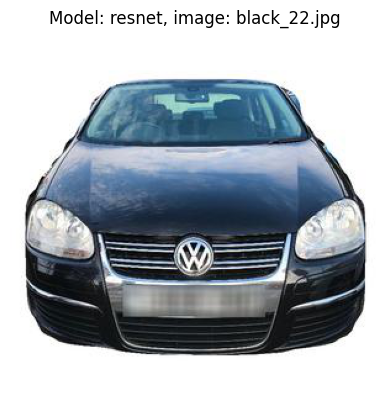

Predicted class: black


/tmp/ipykernel_6912/3584983014.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_ckpt_path, map_location=torch.device('cpu')))


In [33]:
test_one_image('resnet', net_models['resnet'])

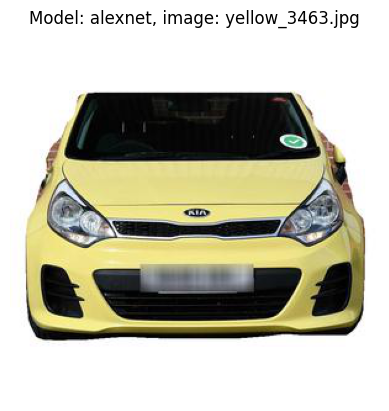

/tmp/ipykernel_6912/3584983014.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_ckpt_path, map_location=torch.device('cpu')))


Predicted class: yellow


In [34]:
test_one_image('alexnet', net_models['alexnet'])

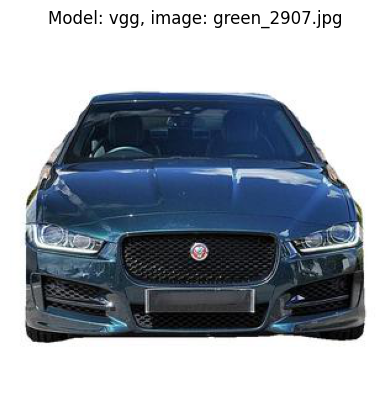

/tmp/ipykernel_6912/3584983014.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_ckpt_path, map_location=torch.device('cpu')))


Predicted class: green


In [35]:
test_one_image('vgg', net_models['vgg'])

### Результаты

### Метрики

In [36]:
qualities = []
for name in list(net_models.keys()):
    quality_data = pd.DataFrame(
        columns=['Loss (Train)', 'Accuracy (Train)', 'F05_macro (Train)', 'F1_macro (Train)', 'Loss (Test)',
                 'Accuracy (Test)', 'F05_macro (Test)', 'F1_macro (Test)'], index=[name])

    epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix = results[name]['train']
    quality_data['Loss (Train)'] = round(float(epoch_loss), 3)
    quality_data['Accuracy (Train)'] = round(float(epoch_acc), 3)
    quality_data['F05_macro (Train)'] = round(float(f05_macro), 3)
    quality_data['F1_macro (Train)'] = round(float(f1_macro), 3)

    epoch_loss, epoch_acc, f05_macro, f1_macro, conf_matrix = results[name]['test']
    quality_data['Loss (Test)'] = round(float(epoch_loss), 3)
    quality_data['Accuracy (Test)'] = round(float(epoch_acc), 3)
    quality_data['F05_macro (Test)'] = round(float(f05_macro), 3)
    quality_data['F1_macro (Test)'] = round(float(f1_macro), 3)

    qualities.append(quality_data)

models_report = pd.concat(qualities)
models_report

Loss (Train)  Accuracy (Train)  F05_macro (Train)  F1_macro (Train)  \
resnet          0.069             0.980              0.980             0.980   
alexnet         0.341             0.870              0.871             0.871   
vgg             0.194             0.932              0.932             0.932   

         Loss (Test)  Accuracy (Test)  F05_macro (Test)  F1_macro (Test)  
resnet         0.568            0.836             0.838            0.836  
alexnet        0.445            0.845             0.848            0.843  
vgg            0.569            0.838             0.836            0.836

### Графики

resnet


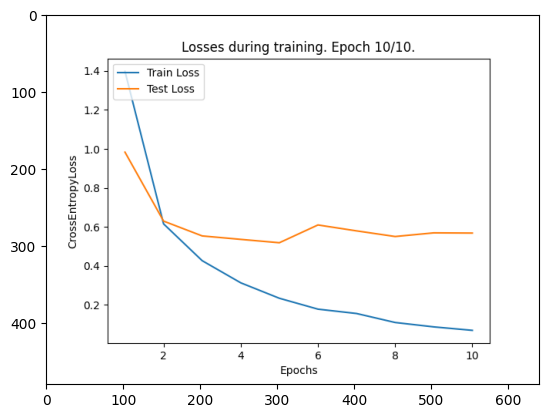

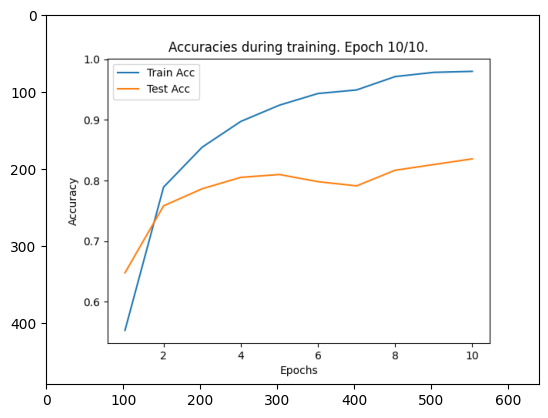

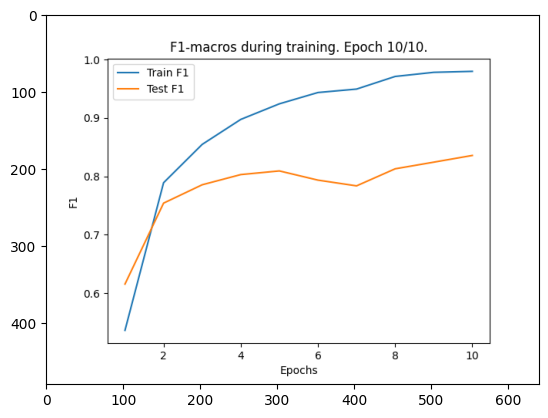

alexnet


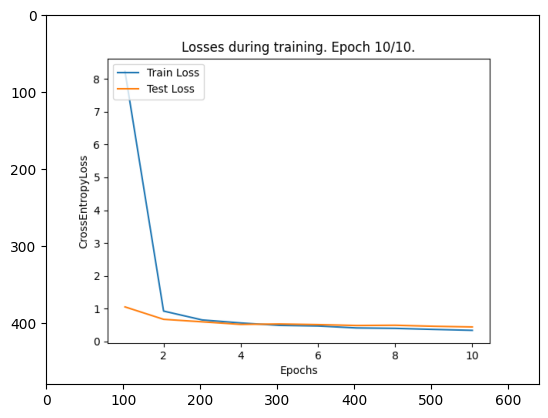

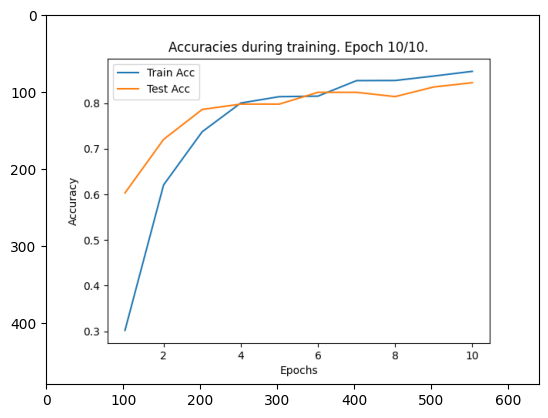

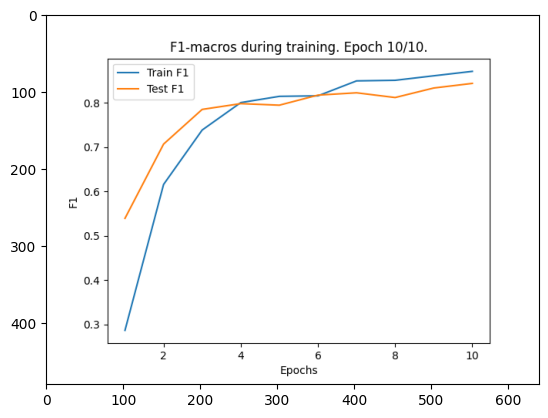

vgg


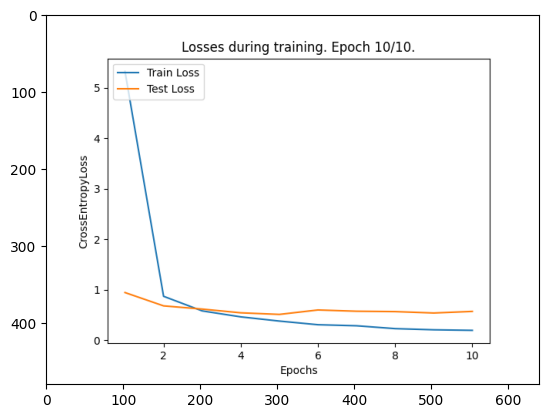

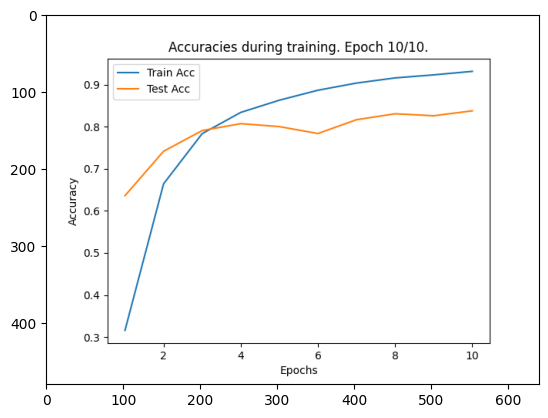

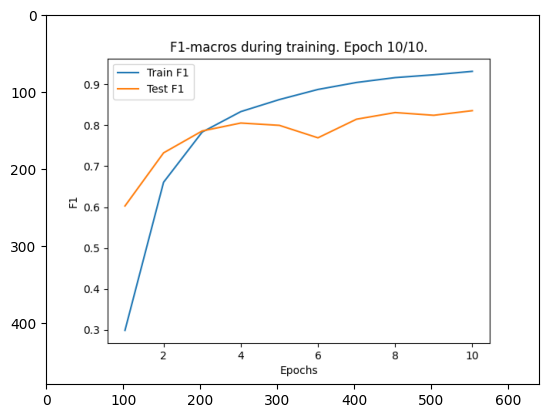

In [37]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for name in list(net_models.keys()):
    print(name)
    img = mpimg.imread(f'{log_folder}/loss_graph_{name}_epoch{num_epochs + 1}.png')
    plt.imshow(img)
    plt.show()
    
    img = mpimg.imread(f'{log_folder}/acc_graph_{name}_epoch{num_epochs + 1}.png')
    plt.imshow(img)
    plt.show()
    
    img = mpimg.imread(f'{log_folder}/f1_graph_{name}_epoch{num_epochs + 1}.png')
    plt.imshow(img)
    plt.show()    

### Confusion Matrix

In [38]:
qualities = []

print(f"{classes}\n")

for name in list(net_models.keys()):
    _, _, _, _, conf_matrix_train = results[name]['train']
    _, _, _, _, conf_matrix_test = results[name]['test']

    print(f"{name} train: \n{conf_matrix_train} \n")
    print(f"{name} test: \n{conf_matrix_test} \n")

['black', 'blue', 'brown', 'green', 'orange', 'red', 'white', 'yellow']

resnet train: 
[[430  10   6   2   0   1   0   0]
 [  7 435   2   4   0   0   0   0]
 [  6   2 436   4   2   0   0   0]
 [  0   1   9 435   0   0   1   1]
 [  0   0   1   0 439   2   0   3]
 [  0   0   1   0   5 439   0   0]
 [  0   0   0   0   0   0 452   0]
 [  1   0   0   0   1   0   0 446]] 

resnet test: 
[[35 10  4  2  0  1  1  0]
 [10 43  0  0  0  0  0  0]
 [ 4  1 42  5  0  0  1  0]
 [ 5  5  5 37  0  0  1  1]
 [ 0  1  3  0 45  2  0  2]
 [ 0  0  0  0  2 51  0  0]
 [ 0  2  1  0  0  0 51  0]
 [ 0  0  0  0  1  0  0 52]] 

alexnet train: 
[[346  83  14   7   0   1   2   0]
 [ 66 359   8   9   0   1   6   0]
 [ 20  19 354  44   5   3   6   0]
 [ 10  17  56 358   0   0   3   4]
 [  2   0   6   2 416  13   0  10]
 [  3   2   2   0  17 418   0   0]
 [  1   0   5   3   0   0 441   0]
 [  0   0   5   4   7   0   0 426]] 

alexnet test: 
[[43  7  1  0  0  1  1  0]
 [17 35  0  0  0  0  1  0]
 [ 2  3 44  3  0  0  1  0]
 

### Выводы:

- обучение проводил на видеокарте nvidia rtx 3090
- попробовал различные предобученные сети, наилучших результатов по качеству обучения удалось достигнуть с:
    - ResNet50
    - AlexNet
    - VGG
- выбрал по 2м причинам: удобно использовать прямо из пакета torchvision и они лучше всего обучились
- попробовал различные гиперпараметры, наилучших результатов по качеству и скорости обучения удалось достигнуть с:
    - 20 эпох
    - размер батча 256
    - 16 воркеров
    - оптимизатор Адам
    - шаг обучения 1e-3
    - функция ошибки CrossEntropyLoss
- Лучший результат по Loss на тесте показала AlexNet (0.208)
- Лучший результат по Accuracy на тесте показала VGG (0.920)
- Лучший результат по F1 Macro на тесте показала AlexNet (0.920)